# Project Background

## 1. Goal
- This project aims to develop a predictive model to forecast the electricity output (CF) of a wind farm based on wind speed data from various locations. The model's performance will be evaluated using the Mean Absolute Error (MAE) metric.
- The primary goal is to build a forecast model that accurately predicts the electricity output (CF) using historical wind speed data.


## 2. Data Source


# Data Schema Review

### Dataset
- **Train Sheet**: Historical data for training the model.
  - Column B – "CF": Target variable (electricity output).
  - Columns C to DJ: Wind speed data from different locations.
- **Predict Sheet**: Data for prediction.

- **112 features**

### Data information
- **Missing Value**: 0
- **Duplicated Value**: 0

# EDA
## Univariate Analysis
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.


## Bivariate analysis
- **Numerical analysis - Correlation**
    1. Our mean wind speed is most correlated with the target value at 0.88, and several other aggregate values also have correlations above 0.7. Therefore, we infer that the distribution of wind speeds from different regions at previous time points is related to the characteristics of the wind speed at the next time point. To avoid overfitting, we can use summary statistics of the wind speeds instead of the original features.

    2. We also checked the wind speeds from different regions, as well as our aggregate wind speed values, for their Pearson and Spearman correlations with the target value. We found that the wind speeds from over 50% of the regions are strongly correlated with the target value.

- **Categorical analysis**
    Based on ANOVA tests, t-tests, and density curves by subgroup, it is evident that there is a strong correlation between seasons and electricity output. Additionally, there is a noticeable relationship between day/night cycles and electricity output.


- **Dual plot：**
    As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

    The analysis reveals that:

    Wind speeds from previous time points influence the current wind speed.
    The current wind speed is strongly correlated with electricity output.
    Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

## Multivariate Analysis

Based on the coefficients from OLS regression and the feature importance from the decision tree, we explored both the linear and nonlinear relationships between features and the target value. This analysis allowed us to perform an initial feature selection.




# Feature Engineering

# Model

### Strategy A（Autogluton Weighted Ensembled L2 regression model）
We use the current time point's wind speed, as well as features such as season and daylight, to predict the electricity output at the current time, without considering the temporal correlation between different time points.


### Strategy B（LSTM， Multivariate time series forecasting model）
We use the wind speed information from previous time points (lagging features) to predict the current electricity output, taking into account the temporal correlation between different time points.

----

# Data Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Ensure matplotlib inline for Jupyter Notebooks
%matplotlib inline

In [2]:
from scipy.stats import shapiro, normaltest, skew, kurtosis, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import statsmodels.formula.api as smf

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import display, Image
# from pdf2image import convert_from_path

from sklearn.model_selection import train_test_split

from autogluon.tabular import TabularPredictor

In [4]:
data = pd.read_excel('Wind_data.xlsx', sheet_name='Train')
predict = pd.read_excel('Wind_data.xlsx', sheet_name='Predict')
data.head()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1366338,WS_1366351,WS_1369320,WS_1461024,WS_1481513,WS_1504146,WS_1513782,WS_1513805,WS_1571308,WS_1574484,WS_1625339,WS_1625374,WS_1628663,WS_1681085,WS_1820276,WS_1820279,WS_1899876,WS_1911282,WS_1937650,WS_1937653,WS_1953863,WS_1960535,WS_2113254,WS_2113394,WS_2118117,WS_2217107,WS_2379547,WS_2385763,WS_2455069,WS_2460378,WS_2467589,WS_2467635,WS_2479335,WS_2479342,WS_2479346,WS_2503597,WS_2508545,WS_2508550,WS_2586062,WS_593968,WS_594133,WS_609612,WS_629008,WS_629020,WS_631992,WS_651000,WS_676278,WS_676403,WS_676534,WS_72720,WS_72721,WS_72733,WS_73450,WS_73451,WS_73494,WS_73822,WS_74020,WS_74022,WS_74124,WS_74158,WS_74180,WS_74243,WS_745977,WS_746023,WS_74719,WS_74884,WS_751132,WS_75213,WS_75287,WS_75812,WS_75931,WS_75932,WS_75933,WS_75934,WS_75935,WS_75936,WS_75955,WS_76003,WS_76004,WS_76275,WS_76434,WS_76888,WS_77067,WS_77080,WS_77363,WS_77370,WS_77682,WS_77683,WS_77720,WS_77740,WS_77985,WS_78026,WS_78205,WS_78207,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,2019-08-07 00:00:00,0.652524,10.35,8.99,4.57,9.69,8.90,2.90,5.74,1.16,8.81,8.74,11.14,6.13,15.46,10.70,9.66,9.72,11.02,9.90,6.79,2.13,7.31,2.09,6.60,8.17,2.33,3.47,8.04,5.71,9.95,10.27,6.41,6.96,5.75,11.13,10.57,10.45,8.99,9.82,5.84,11.90,6.61,5.71,6.58,11.75,11.55,11.92,6.83,8.89,8.34,10.89,10.59,10.71,11.31,10.27,7.52,6.73,10.52,9.96,9.96,10.94,10.56,9.17,11.67,10.67,10.05,11.78,10.71,10.29,8.32,10.47,11.69,10.88,10.32,9.19,8.80,10.44,11.03,10.24,9.96,9.77,11.00,11.16,11.26,11.55,9.10,9.76,10.44,10.58,11.14,11.13,10.85,10.74,11.06,10.10,9.77,9.93,7.07,10.24,8.72,10.73,10.77,9.82,11.12,6.79,9.31,11.63,10.72,10.55,11.41,10.77,10.17,9.24
1,2019-08-07 01:00:00,0.605852,9.70,8.28,5.78,9.10,7.98,2.23,3.46,0.97,7.75,7.88,10.49,5.84,14.90,10.33,9.59,9.64,9.73,9.48,6.43,1.47,6.96,1.44,6.12,7.42,2.25,2.66,7.70,5.53,10.33,9.60,5.82,6.35,5.63,11.29,10.23,10.72,8.92,9.21,5.35,11.25,6.18,5.58,6.14,11.67,11.73,11.99,6.29,7.95,7.96,10.25,9.98,10.04,11.45,10.33,6.92,5.58,9.79,10.74,9.92,11.03,10.64,8.67,11.65,10.88,9.43,11.75,10.04,9.63,7.65,10.69,11.03,10.99,9.65,9.02,7.95,10.35,11.07,9.51,10.74,9.77,11.11,11.42,11.53,11.73,8.13,9.05,9.82,10.77,10.49,11.15,10.22,10.62,11.35,9.96,9.77,9.97,6.65,9.51,7.76,10.39,10.12,9.21,10.47,6.40,9.50,11.10,11.02,9.91,11.16,10.98,10.16,9.09
2,2019-08-07 02:00:00,0.564094,9.04,7.39,6.21,8.98,7.78,1.98,2.62,0.92,7.55,7.70,10.12,5.81,14.22,10.01,9.59,9.63,8.92,9.11,5.99,1.23,7.09,1.21,5.92,6.91,2.30,2.64,7.30,5.25,10.64,8.90,5.60,6.00,5.62,11.36,9.92,10.22,9.01,8.40,5.09,10.86,5.99,5.58,5.96,11.37,11.73,11.90,6.03,7.81,7.55,9.76,9.69,9.58,11.45,10.35,6.72,5.26,9.28,10.71,9.91,11.04,10.67,8.30,11.49,10.99,8.69,11.59,9.58,8.98,7.20,10.78,10.60,11.02,9.00,8.95,7.61,10.16,11.01,9.26,10.71,9.78,11.14,11.54,11.62,11.73,7.90,8.16,9.25,10.85,10.12,11.06,9.78,10.37,11.47,9.75,9.78,9.99,6.43,9.26,7.64,9.93,9.61,8.40,10.10,6.23,9.46,10.74,11.19,9.52,11.00,11.10,10.04,9.04
3,2019-08-07 03:00:00,0.532721,8.78,7.49,6.43,8.84,7.82,1.33,2.43,0.68,7.53,7.77,9.65,5.32,13.53,9.99,9.44,9.47,8.60,8.82,5.86,1.39,6.86,1.37,5.56,6.84,1.79,3.09,7.24,5.23,10.72,8.70,5.86,5.82,5.66,11.38,9.90,10.49,9.35,8.24,4.85,10.76,5.88,5.62,5.87,11.25,11.74,11.84,5.91,7.85,7.50,9.36,9.32,9.22,11.44,10.32,6.88,4.61,9.18,9.84,9.78,11.00,10.63,8.16,11.37,11.07,8.47,11.46,9.22,8.75,6.84,10.87,10.50,10.99,8.76,8.81,7.65,10.01,10.93,9.04,9.84,9.71,11.12,11.60,11.68,11.74,7.92,8.16,8.91,10.93,9.65,10.96,9.41,10.19,11.55,9.60,9.71,9.97,6.22,9.04,7.70,9.57,9.22,8.24,9.67,6.01,9.45,10.65,11.27,9.11,10.93,11.18,10.20,8.89
4,2019-08-07 04:00:00,0.495608,8.23,6.88,6.81,8.52,6.65,1.64,2.45,0.59,6.40,6.60,9.21,5.25,12.84,9.31,9.20,9.22,7.19,8.63,5.22,1.69,5.90,1.66,4.85,6.61,1.90,3.40,7.21,5.29,10.46,8.13,5.61,5.69,5.60,10.98,9.25,10.62,9.18,7.61,4.48,9.94,5.81,5.55,5.80,10.77,11.22,11.35,5.82,6.63,7.43,8.85,8.99,8.96,10.99,10.03,6.64,3.97,8.34,

In [5]:
predict.head()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1366338,WS_1366351,WS_1369320,WS_1461024,WS_1481513,WS_1504146,WS_1513782,WS_1513805,WS_1571308,WS_1574484,WS_1625339,WS_1625374,WS_1628663,WS_1681085,WS_1820276,WS_1820279,WS_1899876,WS_1911282,WS_1937650,WS_1937653,WS_1953863,WS_1960535,WS_2113254,WS_2113394,WS_2118117,WS_2217107,WS_2379547,WS_2385763,WS_2455069,WS_2460378,WS_2467589,WS_2467635,WS_2479335,WS_2479342,WS_2479346,WS_2503597,WS_2508545,WS_2508550,WS_2586062,WS_593968,WS_594133,WS_609612,WS_629008,WS_629020,WS_631992,WS_651000,WS_676278,WS_676403,WS_676534,WS_72720,WS_72721,WS_72733,WS_73450,WS_73451,WS_73494,WS_73822,WS_74020,WS_74022,WS_74124,WS_74158,WS_74180,WS_74243,WS_745977,WS_746023,WS_74719,WS_74884,WS_751132,WS_75213,WS_75287,WS_75812,WS_75931,WS_75932,WS_75933,WS_75934,WS_75935,WS_75936,WS_75955,WS_76003,WS_76004,WS_76275,WS_76434,WS_76888,WS_77067,WS_77080,WS_77363,WS_77370,WS_77682,WS_77683,WS_77720,WS_77740,WS_77985,WS_78026,WS_78205,WS_78207,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,2020-01-09 00:00:00,NaN,1.69,1.88,3.15,0.92,2.27,1.14,1.24,2.98,2.53,2.18,1.55,1.59,1.10,2.09,1.44,1.43,1.23,1.51,1.15,1.22,2.29,1.24,1.09,0.83,2.78,2.28,1.42,1.77,10.07,2.01,2.50,3.04,3.20,1.38,2.08,9.10,1.16,1.98,1.60,1.44,3.25,3.18,3.18,0.83,1.18,1.08,3.20,2.40,1.27,1.68,0.98,0.93,1.34,1.31,1.90,1.28,1.99,1.44,1.39,1.42,1.35,1.02,1.31,1.08,1.52,1.28,0.93,2.13,1.54,0.97,1.61,1.38,2.09,1.47,2.08,1.50,1.47,0.77,1.44,1.35,1.41,1.24,1.16,1.18,2.40,1.95,1.44,1.05,1.55,1.45,1.19,1.39,1.17,1.47,1.35,1.31,1.35,0.77,2.38,1.94,1.95,1.98,1.40,1.27,1.27,1.43,1.28,1.91,1.12,1.15,1.35,1.46
1,2020-01-09 01:00:00,NaN,1.60,2.02,3.91,0.44,2.36,1.15,1.63,2.83,2.84,2.20,1.17,1.66,1.28,2.43,1.38,1.37,1.95,1.49,1.65,1.46,2.33,1.49,1.10,1.19,2.79,2.45,1.03,1.37,9.97,2.04,1.72,4.72,4.62,1.60,2.46,8.29,1.03,2.13,3.25,2.14,4.95,4.60,4.88,1.11,1.24,0.92,4.97,2.58,0.89,1.41,0.83,1.04,1.47,1.37,1.26,1.22,3.38,1.37,1.38,1.52,1.45,0.80,1.07,1.21,1.42,1.01,1.04,2.15,1.68,1.06,2.43,1.50,2.10,1.27,2.08,1.31,1.47,0.79,1.37,1.32,1.54,1.53,1.37,1.24,2.57,2.10,1.22,1.16,1.17,1.39,0.86,1.11,1.46,1.29,1.32,1.31,1.13,0.79,2.67,1.71,1.85,2.13,1.02,1.11,1.43,2.04,1.60,1.57,1.03,1.28,1.49,1.29
2,2020-01-09 02:00:00,NaN,1.79,2.14,4.20,0.65,2.06,1.28,2.36,3.07,2.34,1.94,1.55,1.82,1.29,3.49,1.64,1.60,2.94,1.68,1.92,1.31,2.05,1.28,0.90,0.80,2.04,3.24,0.81,1.00,9.79,2.17,1.37,5.27,5.17,1.71,3.62,7.65,0.91,2.22,3.64,3.28,5.60,5.14,5.68,0.97,1.26,0.86,5.64,2.14,0.79,1.69,1.03,1.39,1.52,1.62,1.04,1.31,4.59,1.61,1.59,1.60,1.63,0.85,1.14,1.50,1.62,1.11,1.39,2.26,1.64,1.35,3.63,1.62,2.22,1.54,2.03,1.35,1.48,0.88,1.61,1.65,1.63,1.65,1.42,1.26,2.17,2.20,1.49,1.45,1.33,1.40,1.18,1.31,1.57,1.34,1.65,1.63,1.43,0.88,2.19,1.93,1.99,2.22,1.39,1.42,1.42,2.91,1.81,1.85,1.10,1.56,1.54,1.56
3,2020-01-09 03:00:00,NaN,2.01,2.32,5.17,0.51,2.31,0.83,3.39,3.38,2.53,2.26,1.73,1.72,1.04,2.77,2.27,2.19,3.73,1.78,2.39,1.63,2.11,1.61,0.82,1.12,3.18,3.37,0.89,0.91,9.72,2.47,1.52,5.47,4.98,2.19,2.91,6.99,0.78,1.80,3.59,2.99,5.54,4.97,5.59,1.05,1.60,1.19,5.71,2.48,0.86,1.91,1.18,1.51,1.94,2.27,1.11,1.50,4.72,2.23,2.18,2.10,2.23,0.89,1.54,2.06,1.79,1.48,1.51,2.59,1.78,1.88,3.50,2.14,2.54,2.16,2.17,1.77,1.93,1.03,2.23,2.36,2.12,2.00,1.73,1.61,2.37,2.43,1.66,2.07,1.73,1.85,1.31,1.59,1.87,1.73,2.36,2.39,1.81,1.03,2.52,2.21,2.31,1.80,1.55,2.01,1.26,2.49,2.09,2.09,1.06,2.12,1.66,2.18
4,2020-01-09 04:00:00,NaN,2.12,2.54,4.19,0.77,4.52,0.97,2.89,3.79,4.21,4.46,1.58,2.23,1.08,1.83,2.69,2.60,2.15,1.94,3.08,1.90,4.61,1.88,1.10,1.36,3.21,4.67,0.89,0.92,9.26,2.49,1.13,6.49,5.18,2.45,1.78,5.59,1.24,2.59,4.49,1.40,6.07,5.18,6.09,0.89,1.81,1.39,6.35,4.43,0.85,1.98,1.28,1.63,2.22,2.66,0.92,1.52,2.64,2.64,2.59,2.46,2.62,0.91,1.81,2.29,1.97,1.73,1.63,2.56,2.01,2.13,1.63,2.51,2.53,2.58,4.52,2.15,2.32,1.16,2.64,2.78,2.45,2.17,1.91,1.81,4.58,2.58,1.81,2.36,1.58,2.22,1.43,1.86,2.03,2.11,2.78,2.80,2.17,1.16,4.

In [6]:
data.shape

(3635, 114)

In [7]:
predict.shape

(93, 114)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 114 entries, DATETIME to WS_921049
dtypes: datetime64[ns](1), float64(113)
memory usage: 3.2 MB


In [9]:
data.describe()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1366338,WS_1366351,WS_1369320,WS_1461024,WS_1481513,WS_1504146,WS_1513782,WS_1513805,WS_1571308,WS_1574484,WS_1625339,WS_1625374,WS_1628663,WS_1681085,WS_1820276,WS_1820279,WS_1899876,WS_1911282,WS_1937650,WS_1937653,WS_1953863,WS_1960535,WS_2113254,WS_2113394,WS_2118117,WS_2217107,WS_2379547,WS_2385763,WS_2455069,WS_2460378,WS_2467589,WS_2467635,WS_2479335,WS_2479342,WS_2479346,WS_2503597,WS_2508545,WS_2508550,WS_2586062,WS_593968,WS_594133,WS_609612,WS_629008,WS_629020,WS_631992,WS_651000,WS_676278,WS_676403,WS_676534,WS_72720,WS_72721,WS_72733,WS_73450,WS_73451,WS_73494,WS_73822,WS_74020,WS_74022,WS_74124,WS_74158,WS_74180,WS_74243,WS_745977,WS_746023,WS_74719,WS_74884,WS_751132,WS_75213,WS_75287,WS_75812,WS_75931,WS_75932,WS_75933,WS_75934,WS_75935,WS_75936,WS_75955,WS_76003,WS_76004,WS_76275,WS_76434,WS_76888,WS_77067,WS_77080,WS_77363,WS_77370,WS_77682,WS_77683,WS_77720,WS_77740,WS_77985,WS_78026,WS_78205,WS_78207,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
count,3635,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.00000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000
mean,2019-10-22 23:15:08.170564096,0.186114,4.532563,3.943094,5.124113,5.118909,5.558190,2.524281,3.927272,3.388721,5.787298,5.400131,5.113265,3.082812,5.11004,4.746591,5.601653,5.616028,4.737436,5.419089,4.611172,3.048772,4.935458,3.007634,4.193014,4.868281,4.623131,4.751107,5.365917,4.848912,8.409858,4.425622,5.628596,4.070714,3.789662,6.180083,4.750312,7.908671,5.288048,4.301199,3.745168,4.940121,3.959948,3.775190,3.911803,5.862967,6.320652,6.363132,4.011699,5.691146,5.350600,4.812928,5.290014,5.211409,6.244582,5.792254,5.617801,3.790268,4.716799,5.839609,5.689281,6.088477,5.920525,5.356691,6.300305,5.900298,4.482239,6.324001,5.212157,4.463615,3.742041,5.787191,4.932922,6.055241,4.464967,5.412726,5.399583,5.895950,6.135318,5.290395,5.841851,5.612688,6.115190,6.246078,6.286209,6.320492,5.719968,4.190906,4.717487,5.846501,5.115040,6.167868,5.149120,6.021008,6.236454,5.740915,5.612688,5.659557,4.755939,5.289847,5.668107,5.904085,4.711924,4.306805,5.126252,4.689553,5.455680,4.789538,6.083490,4.860514,5.756882,5.958355,5.699761,5.435894
min,2019-08-07 00:00:00,0.003551,0.590000,0.490000,0.680000,0.460000,0.530000,0.500000,0.310000,0.240000,0.570000,0.510000,0.660000,0.330000,0.46000,0.580000,0.540000,0.490000,0.410000,0.560000,0.690000,0.320000,0.530000,0.320000,0.450000,0.410000,0.560000,0.430000,0.590000,0.510000,0.800000,0.530000,0.560000,0.520000,0.480000,0.650000,0.580000,0.970000,0.420000,0.560000,0.360000,0.480000,0.430000,0.480000,0.390000,0.470000,0.460000,0.430000,

### No Missing Value

In [10]:
sum(data.isnull().any())

0

### No Duplicated values

In [11]:
data.duplicated().value_counts()

False    3635
Name: count, dtype: int64

# Exploratory Data Analysis

In [12]:
# Make sure the data is sorted by datetime
data.set_index('DATETIME', inplace=True)

# Get all columns of Wind Speed from different locations
ws_columns = [col for col in data.columns if col.startswith('WS_')]

In [13]:
predict.set_index('DATETIME', inplace=True)

# EDA
## Univariate Analysis
- Numerical Variable Distribution

In [14]:
# Determine Distribution
def determine_distribution(df):
    """
    Analyzes the distribution characteristics of each column in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame summarizing the distribution characteristics of each column.
    """
    results = []
    for column in df.columns:
        data = df[column]

        # Calculate max, min, mean, std, and median
        max_val = data.max()
        min_val = data.min()
        mean_val = data.mean()
        std_val = data.std()
        median_val = data.median()

        # Normality tests
        stat, p_value_normal = shapiro(data)
        stat_k2, p_value_k2 = normaltest(data)

        # Skewness and kurtosis
        skewness = skew(data)
        kurt = kurtosis(data)

        # Determine distribution type
        if p_value_normal > 0.05 and p_value_k2 > 0.05:
            dist_type = 'Normal Distribution'
        elif np.abs(skewness) < 0.5 and np.abs(kurt) < 3:
            dist_type = 'Uniform Distribution'
        else:
            dist_type = 'Skewed Distribution'

        results.append({
            'Column': column,
            'Min': min_val,
            'Median': median_val,
            'Max': max_val,
            'Mean': mean_val,
            'Std': std_val,
            'Distribution Type': dist_type
        })

    return pd.DataFrame(results)

In [15]:
distribution_results = determine_distribution(data.drop('CF', axis=1))
distribution_results

,Column,Min,Median,Max,Mean,Std,Distribution Type
0,WS_1133733,0.59,3.66,14.66,4.532563,2.790853,Skewed Distribution
1,WS_1156770,0.49,3.22,13.13,3.943094,2.371923,Skewed Distribution
2,WS_1156968,0.68,4.78,14.64,5.124113,2.712505,Skewed Distribution
3,WS_1182195,0.46,4.49,23.04,5.118909,3.213767,Skewed Distribution
4,WS_1193865,0.53,5.36,17.43,5.558190,2.691479,Uniform Distribution
5,WS_1321569,0.50,2.01,13.20,2.524281,1.655931,Skewed Distribution
6,WS_1324653,0.31,3.34,11.81,3.927272,2.398751,Skewed Distribution
7,WS_1358699,0.24,2.46,19.15,3.388721,2.834749,Skewed Distribution
8,WS_1366338,0.57,5.63,17.09,5.787298,2.834219,Uniform Distribution
9,WS_1366351,0.51,5.23,17.37,5.400131,2.608748,Uniform Distribution


In [16]:
distribution_results_df = distribution_results['Distribution Type'].value_counts().reset_index()
distribution_results_df

,Distribution Type,count
0,Skewed Distribution,93
1,Uniform Distribution,19


There are 93 features follow Skewed Distribution, 19 features follow Uniform Distribution.

In [17]:
column_Skewed = distribution_results[distribution_results['Distribution Type'] == 'Skewed Distribution']['Column']
column_Uniform = distribution_results[distribution_results['Distribution Type'] == 'Uniform Distribution']['Column']

In [18]:
def plot_histograms(df, batch_size=10):
    """
    Plots histograms for the columns in the DataFrame in batches.

    Args:
        df (pd.DataFrame): The input DataFrame.
        batch_size (int): The number of columns to include in each batch of histograms.
    """
    num_columns = len(df.columns)
    for start in range(0, num_columns, batch_size):
        end = min(start + batch_size, num_columns)
        columns_batch = df.columns[start:end]
        df[columns_batch].hist(figsize=(15, 10), bins=20)
        plt.tight_layout()
        plt.show()

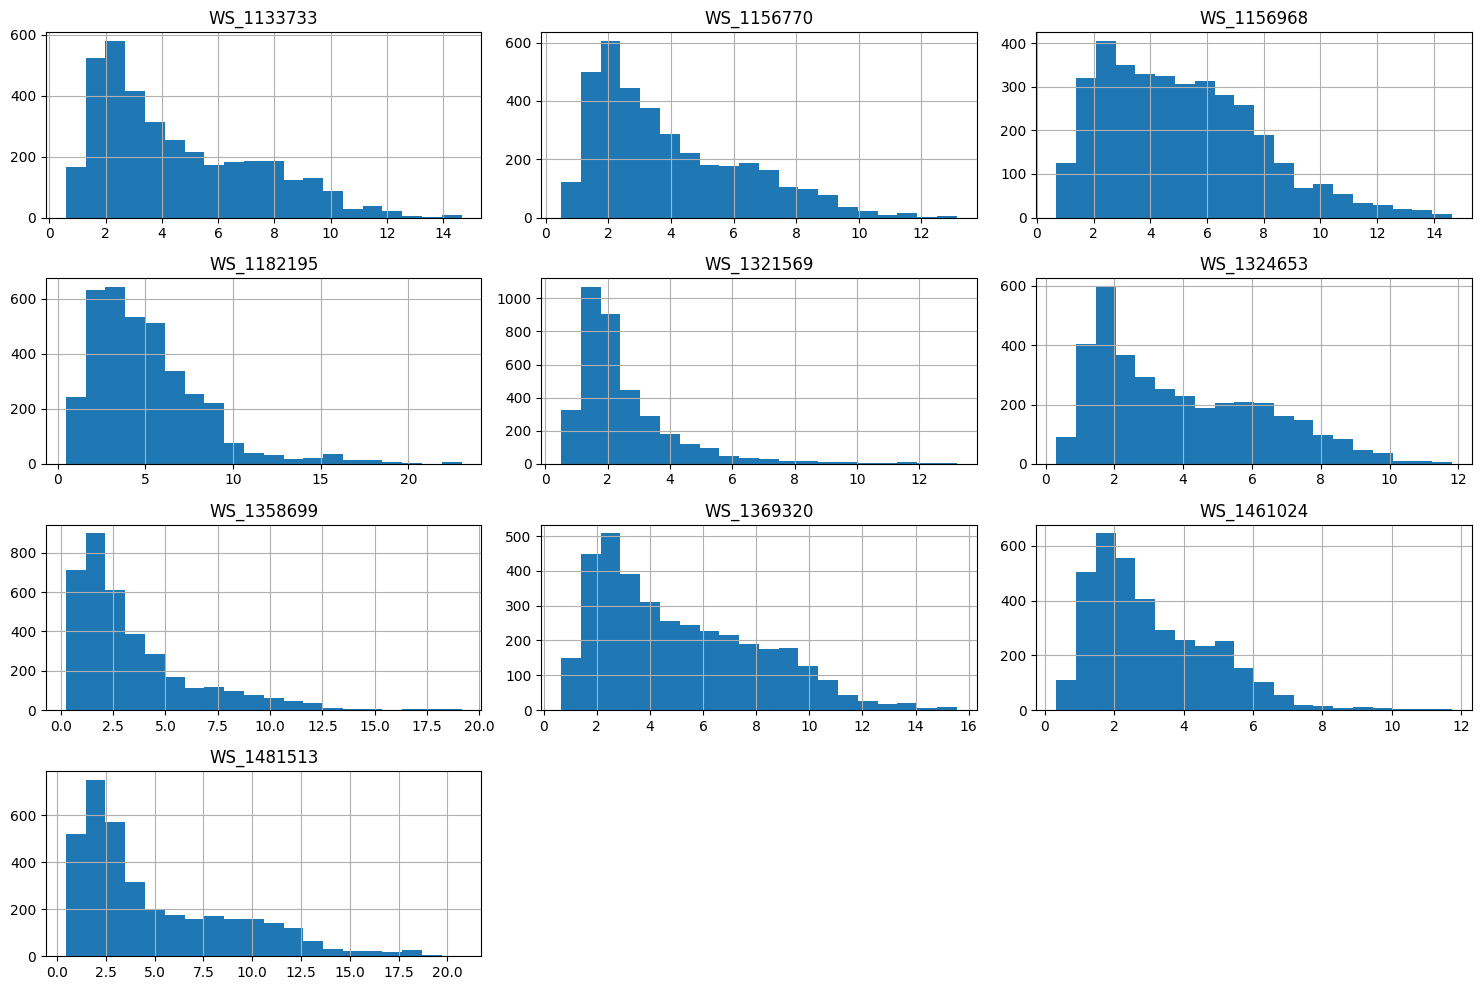

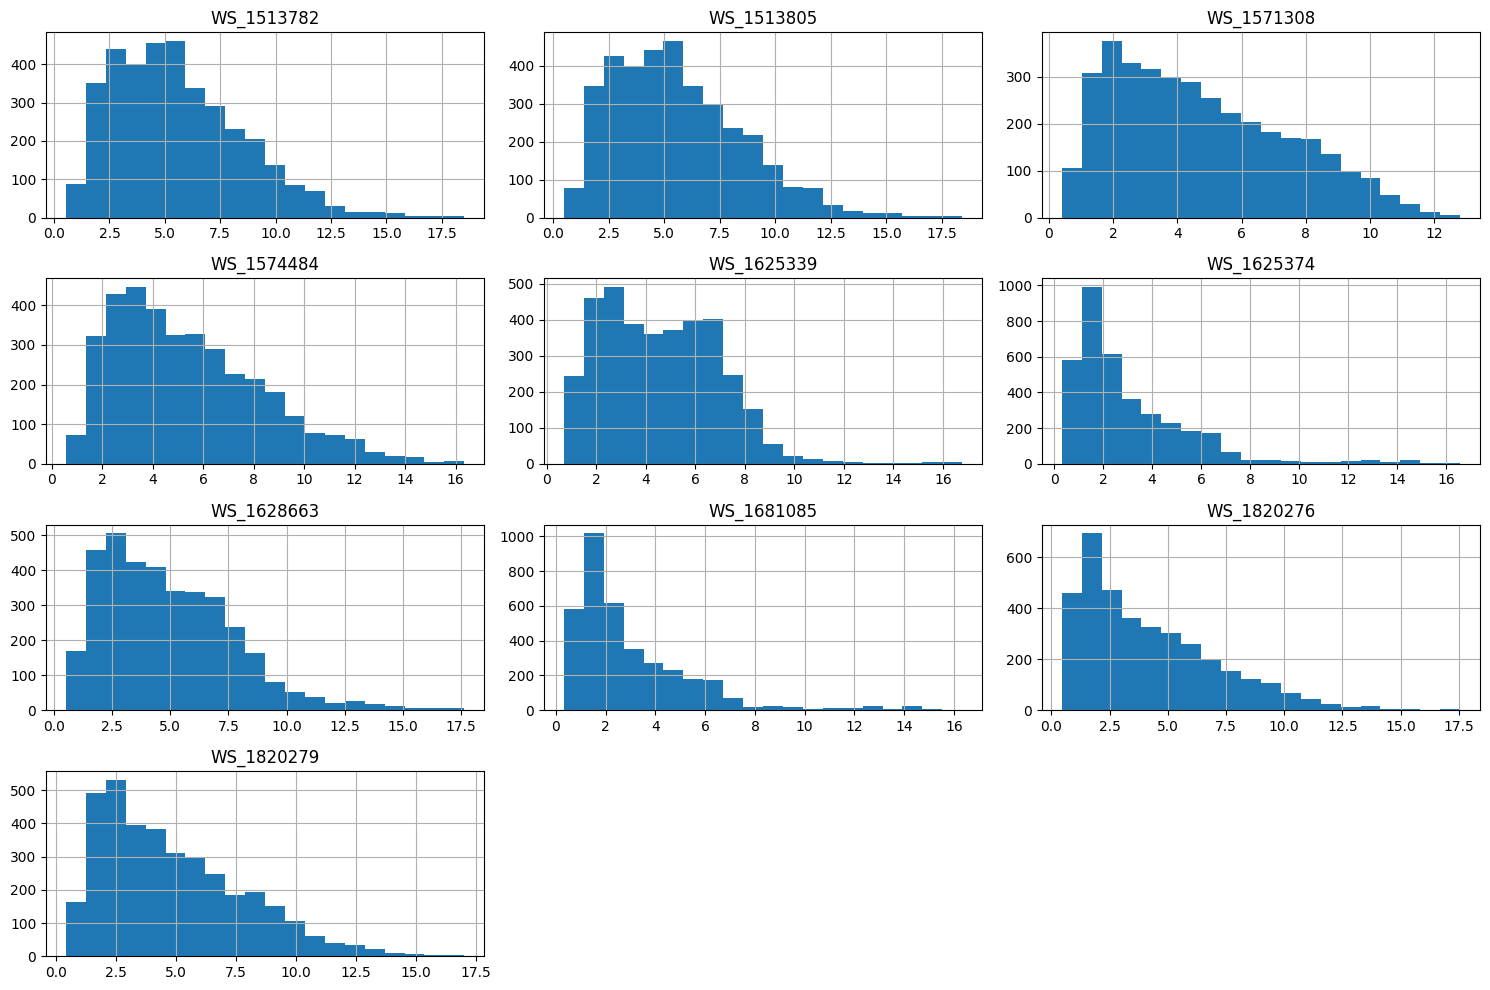

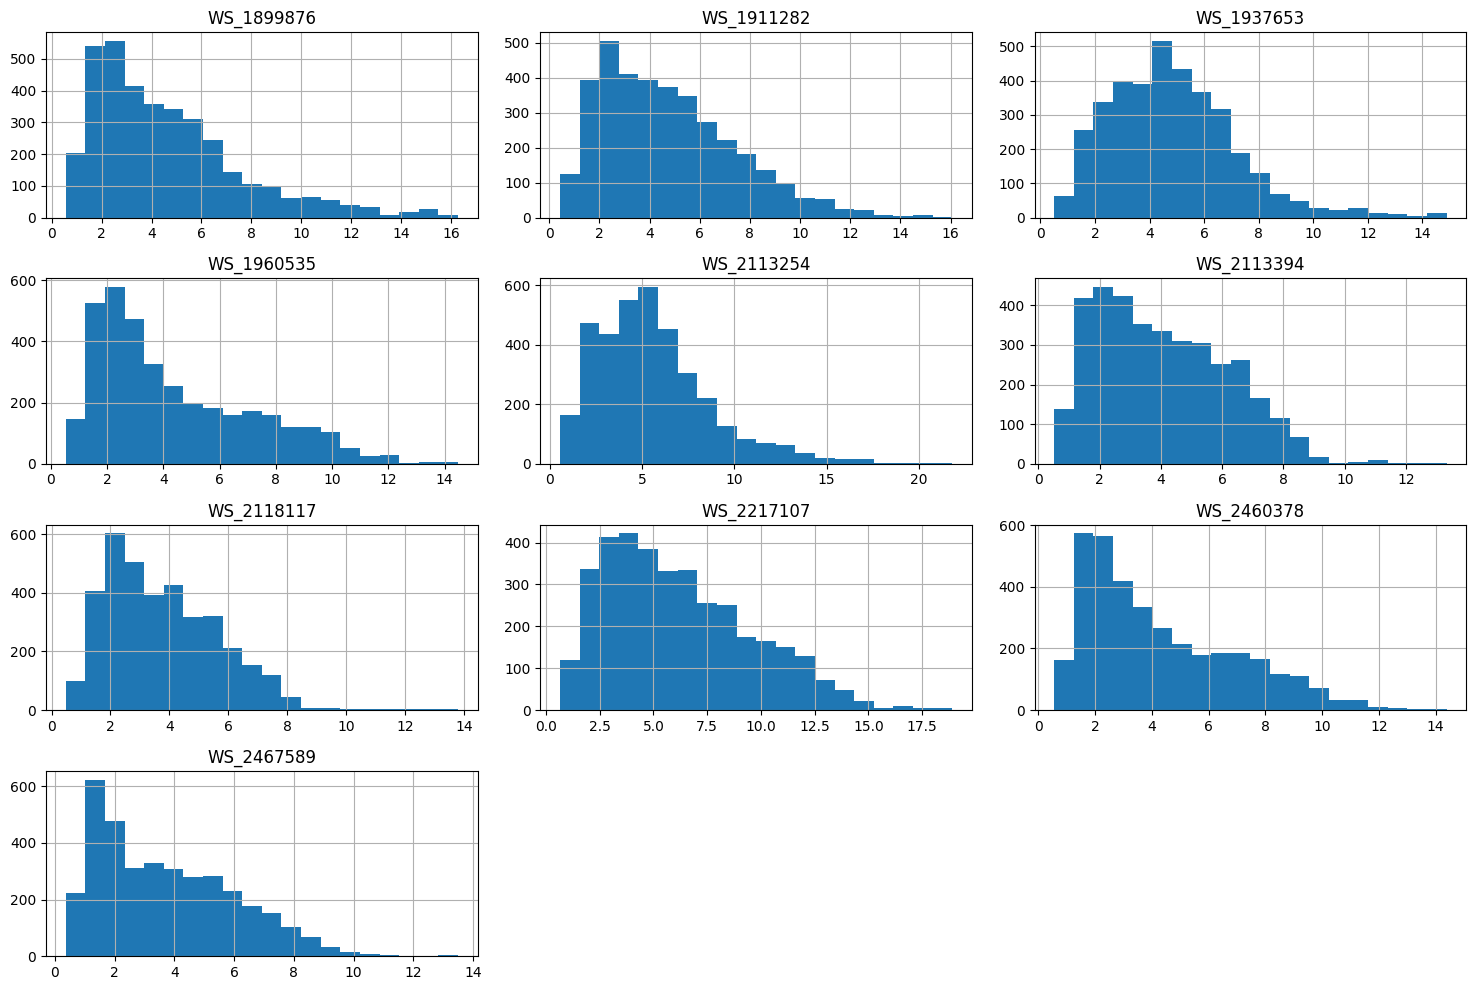

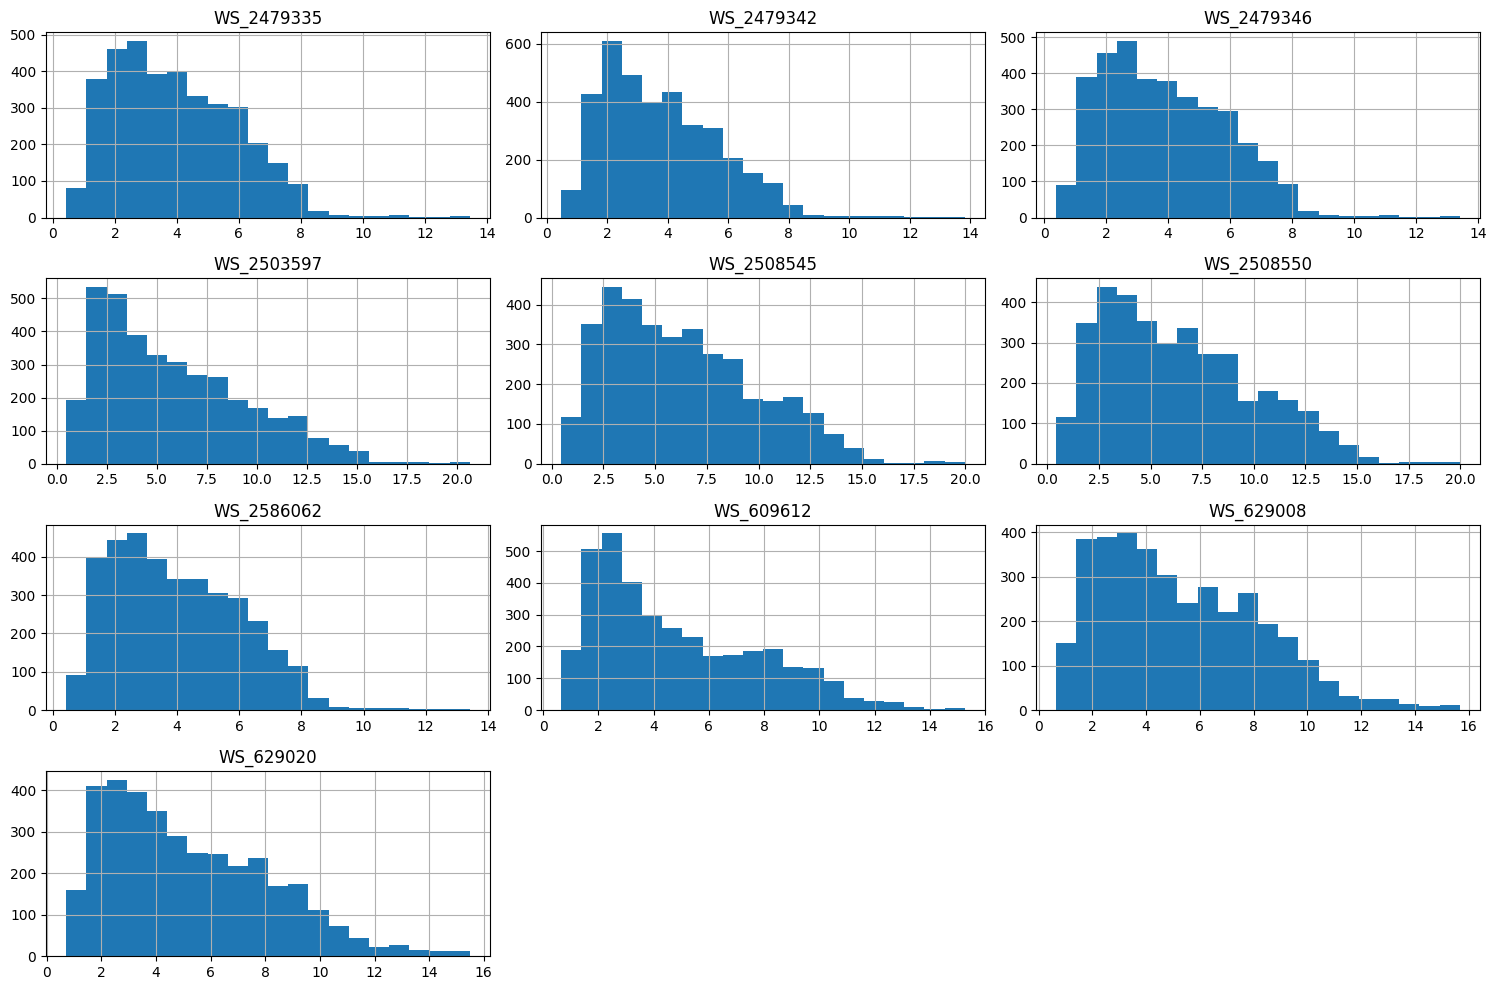

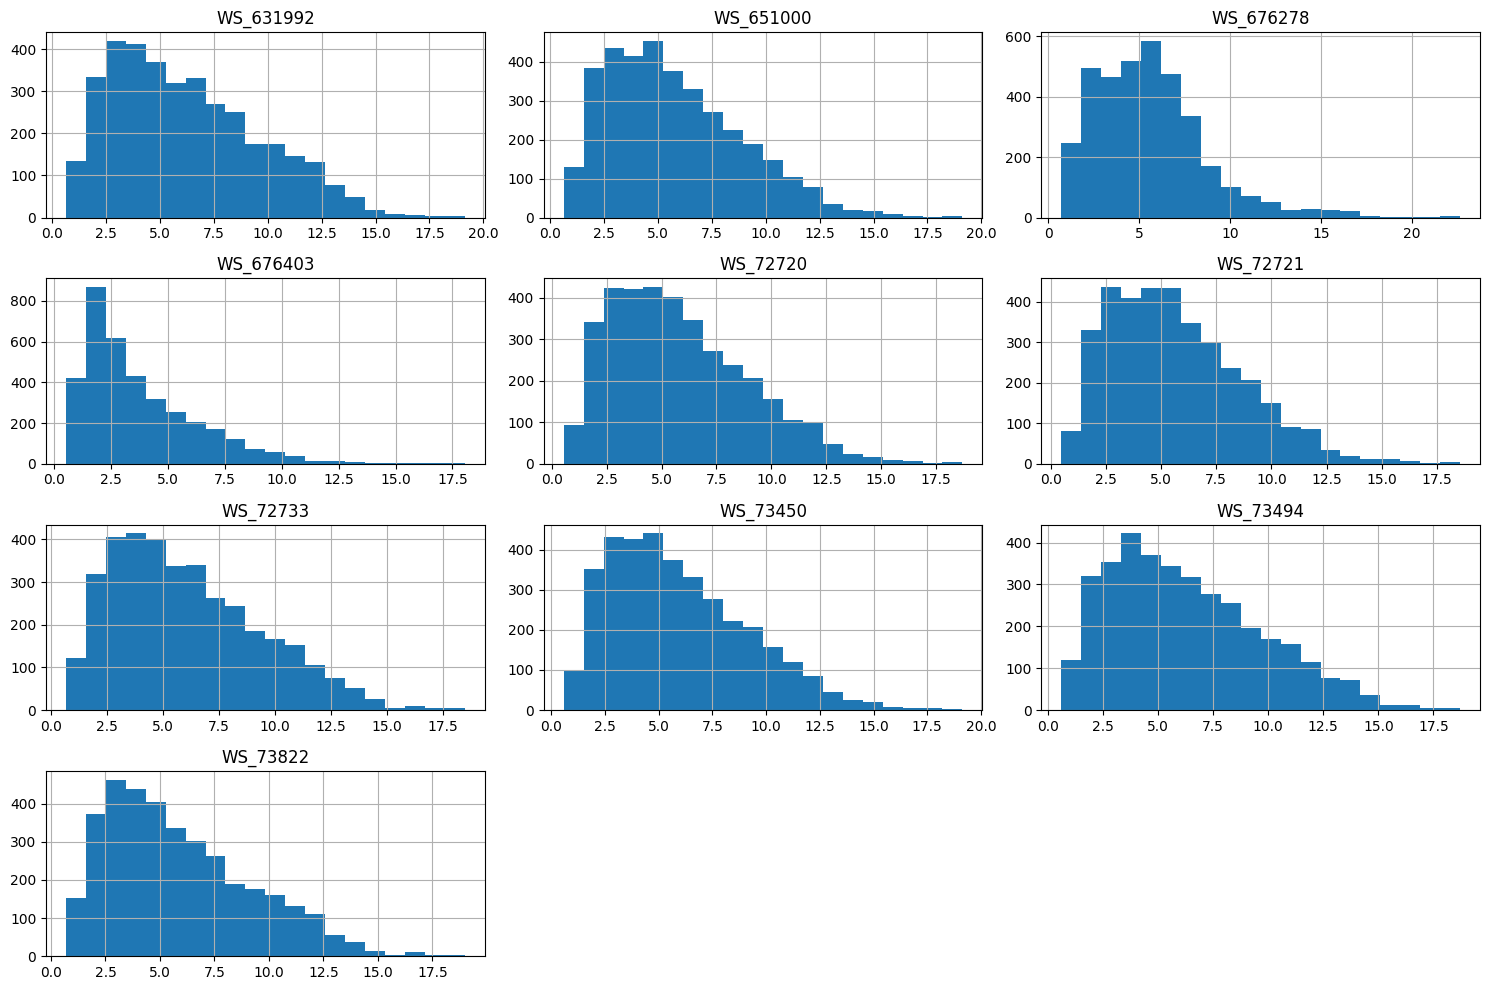

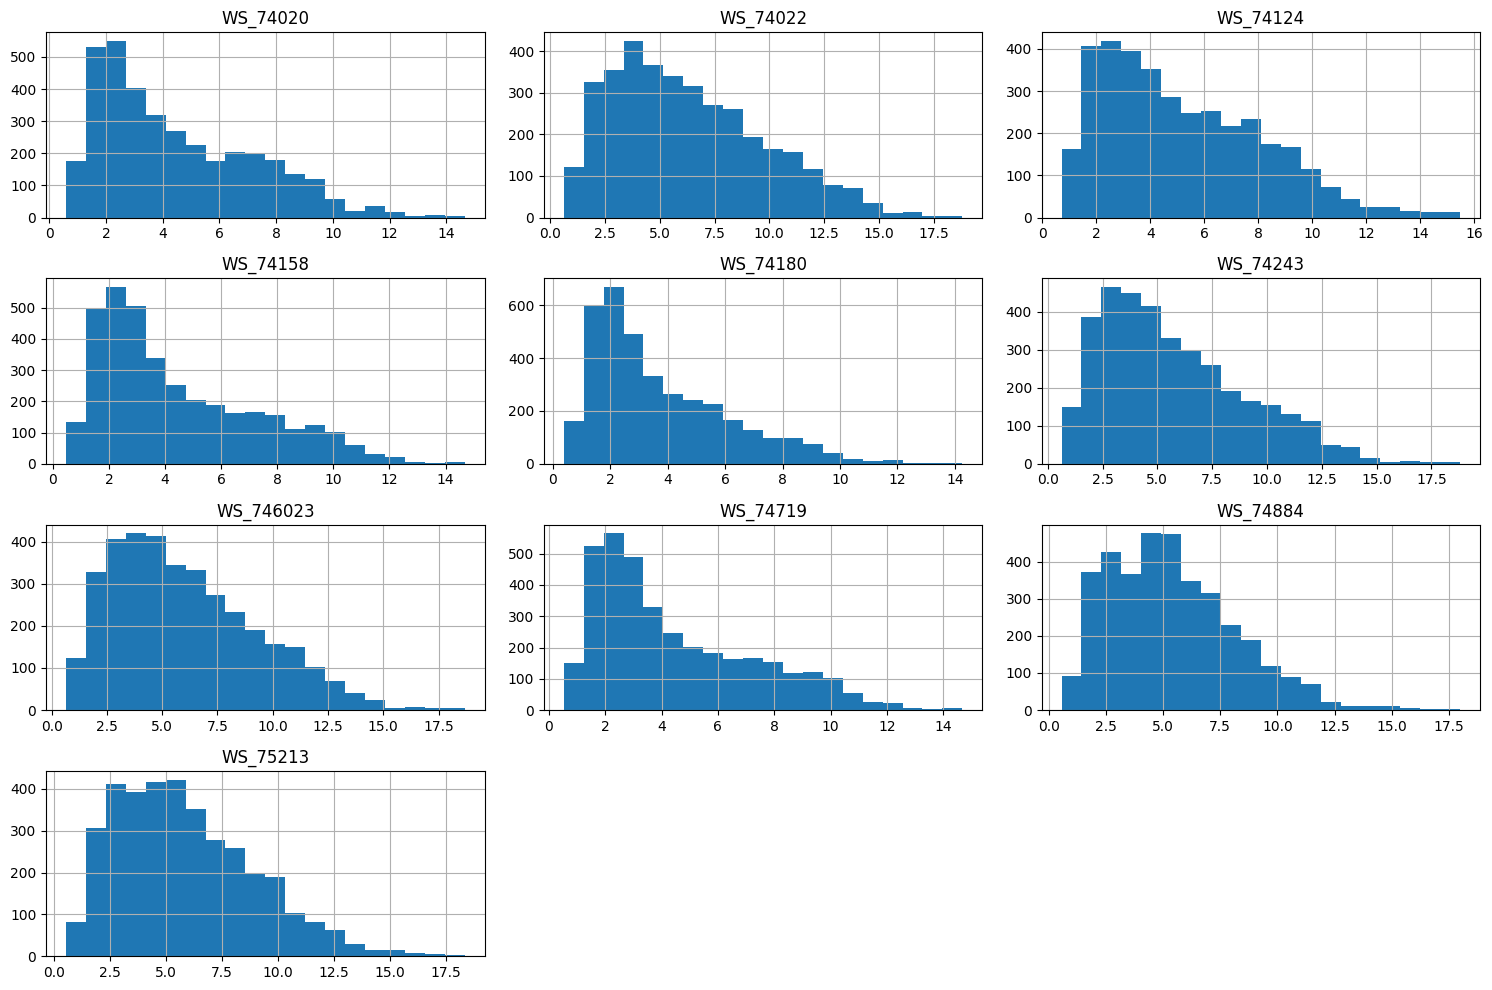

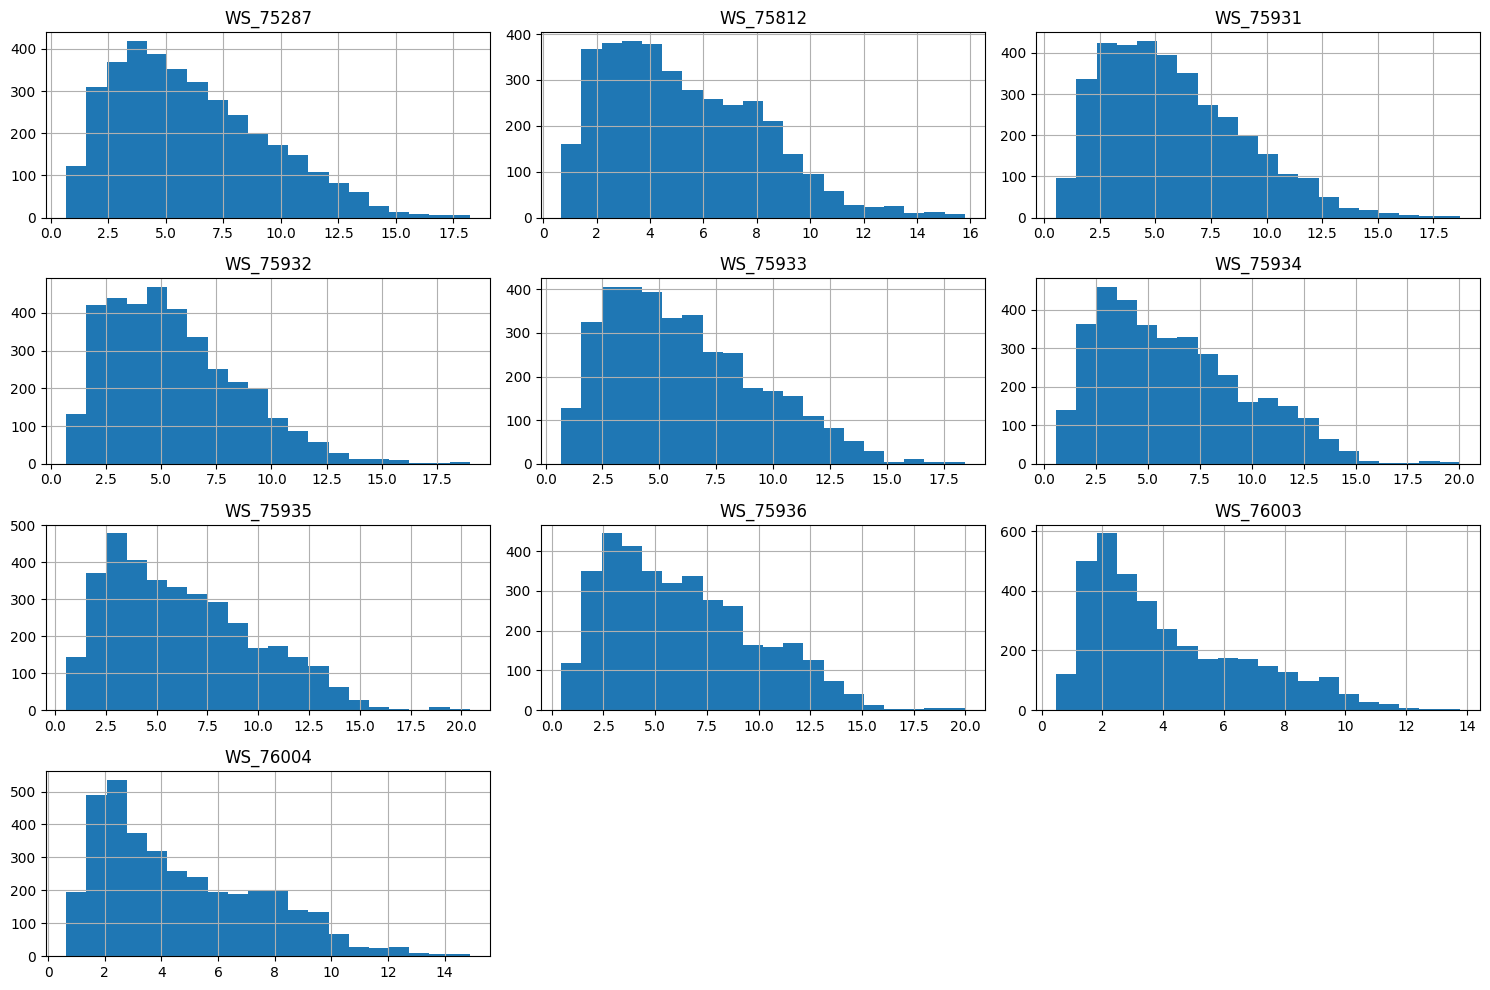

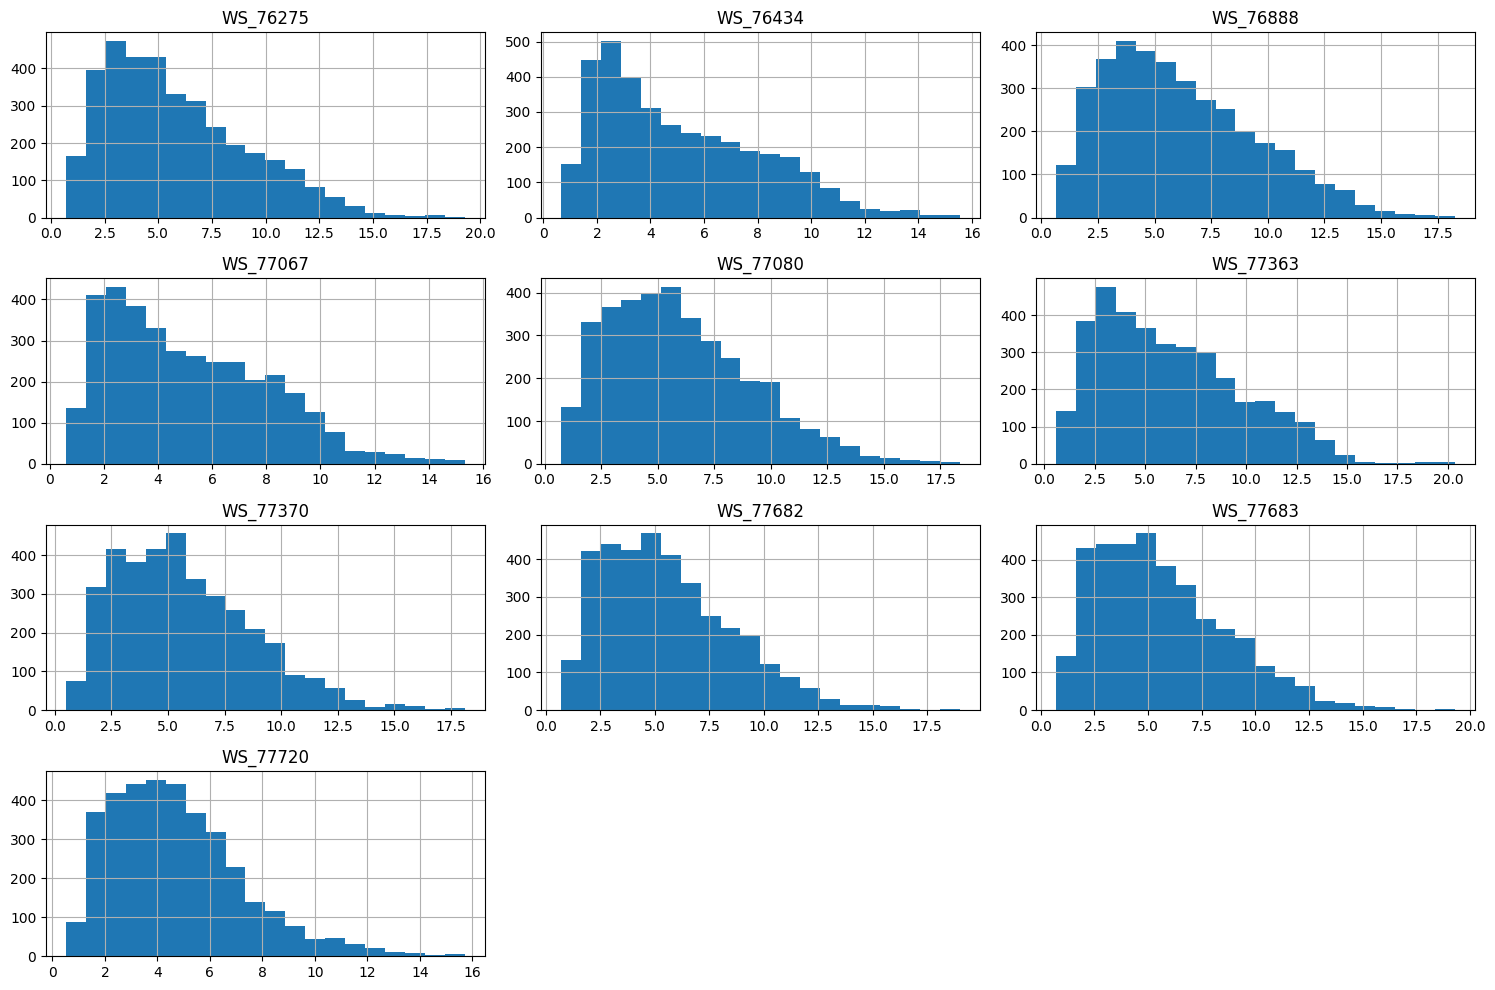

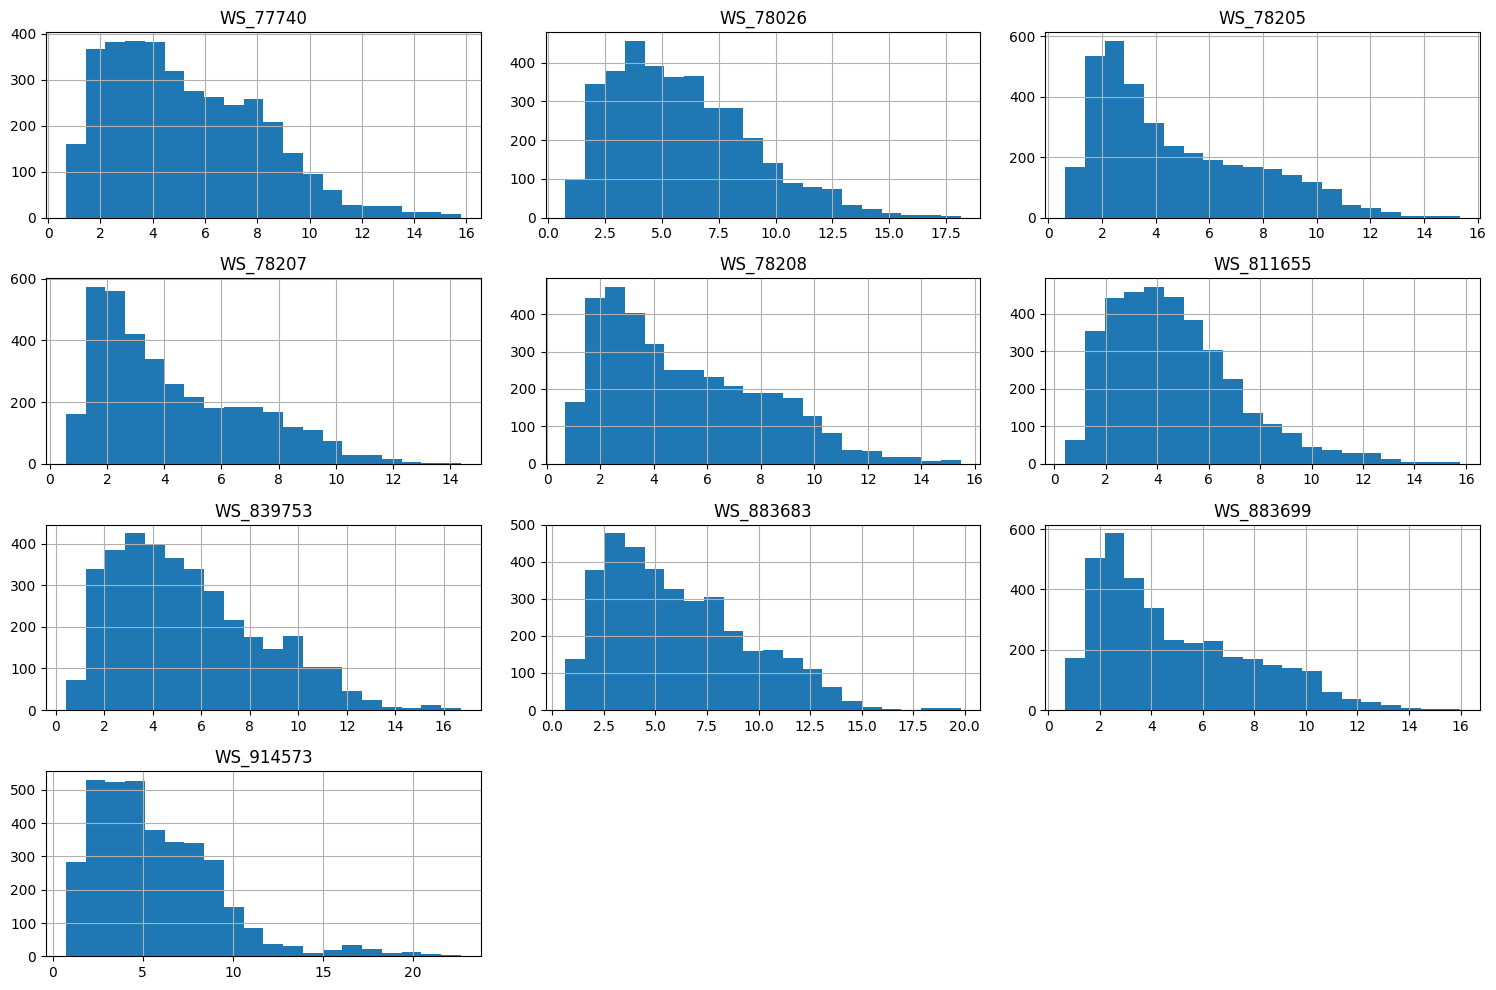

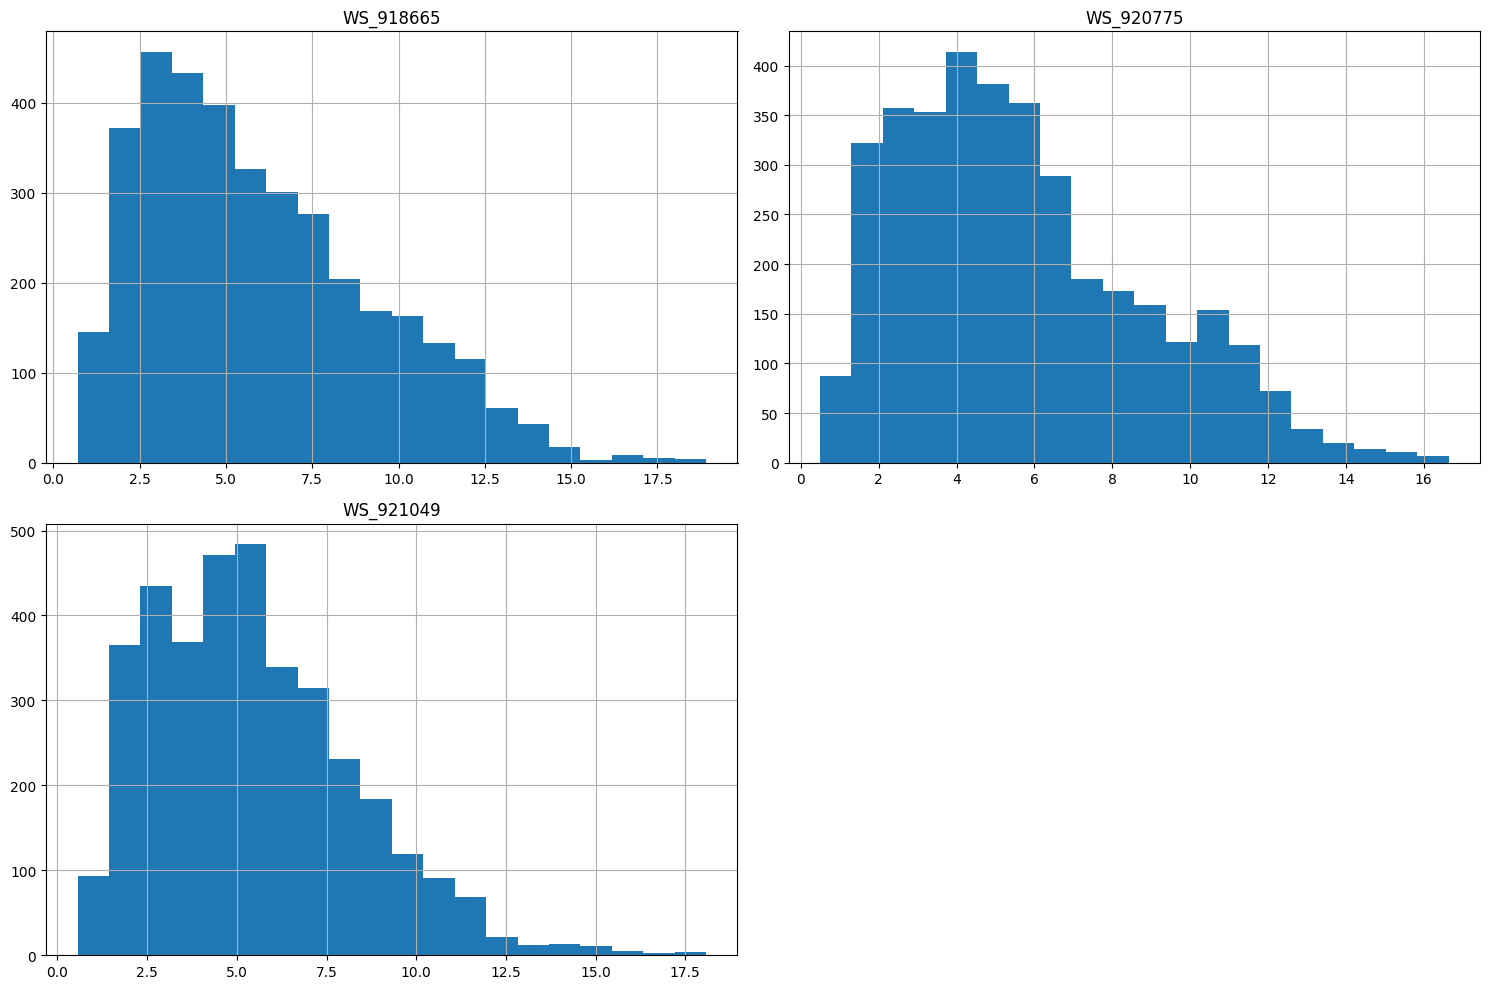

In [19]:
# Plot histograms for features that follow Skewed Distribution.
plot_histograms(data[column_Skewed], batch_size=10)

Above are histograms of features that follow Skewed Distribution.

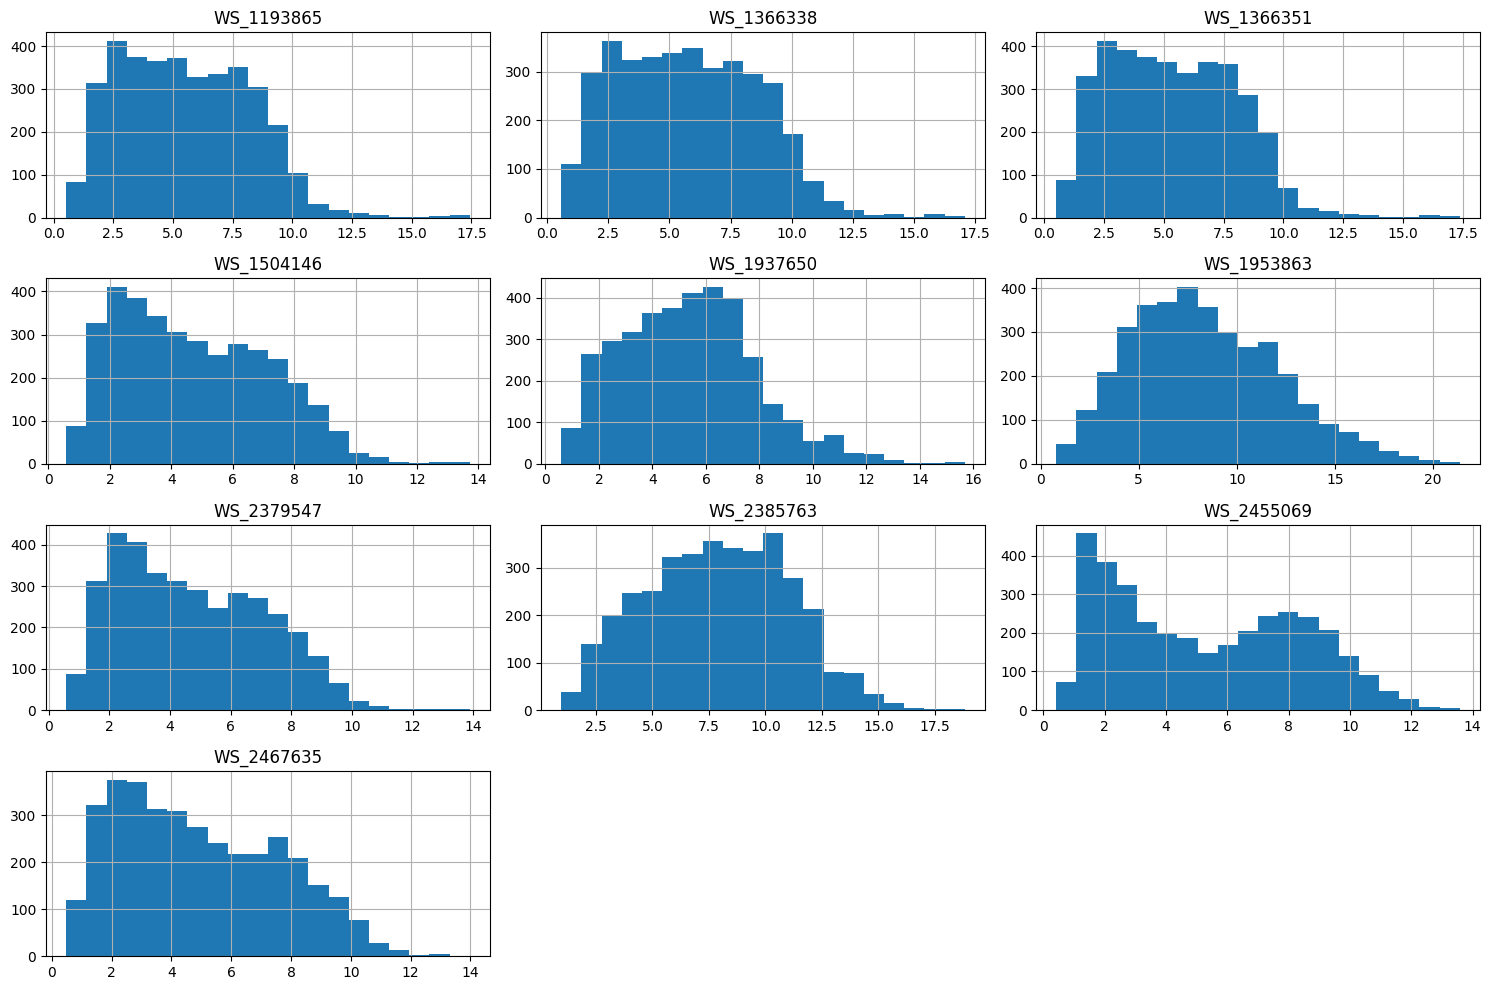

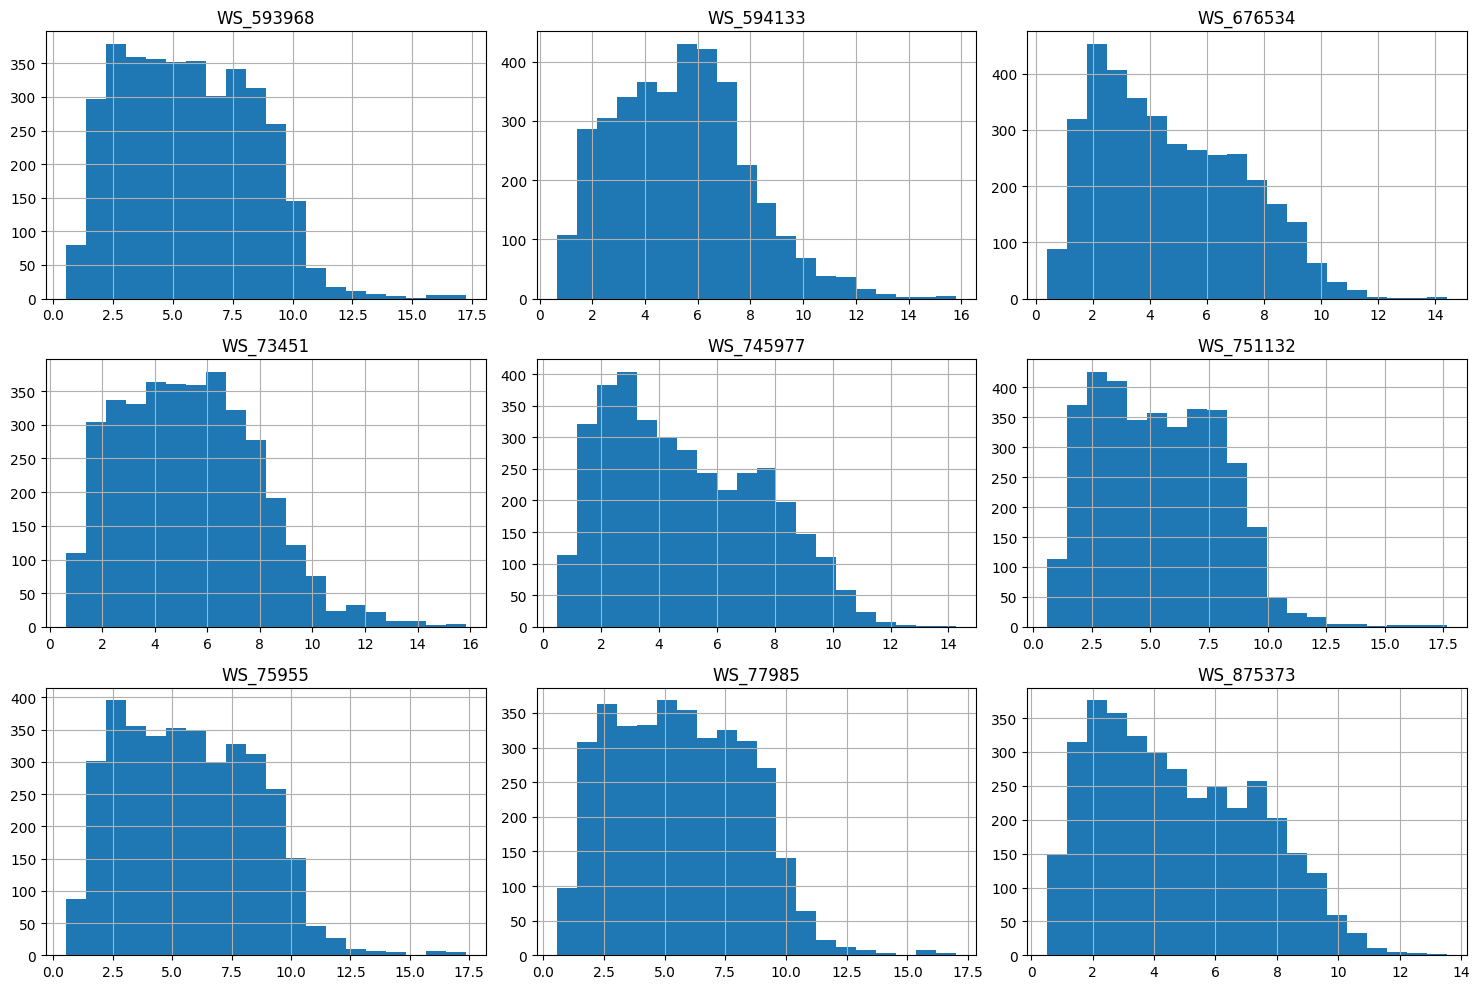

In [20]:
# Plot histograms for features that follow Uniform Distribution.
plot_histograms(data[column_Uniform], batch_size=10)

Above are histograms of features that follow Uniform Distribution.

**Brief summary about raw data:**

**1. Mean and Median Proximity**:
    The mean and median of the features are quite close, indicating a symmetrical distribution of data without significant skewness.

**2. Reasonable Range for Min and Max Values**:
    Both the minimum and maximum values of the features fall within reasonable ranges, suggesting the absence of outliers in the data.

**3. Comparable Standard Deviations**:
    The standard deviations of the features are similar in magnitude, indicating a consistent level of variability across different features.

**4. Distribution Characteristics**:
    From the histograms and numerical summaries of the distributions, it was observed that the wind speed values in most locations are approximately normally distributed.
    In a few locations, the wind speed distribution appears to be nearly uniform.

Now here is the distribution of each row in the dataset:

In [21]:
row_distribution_results = determine_distribution(data.drop('CF', axis=1).T)
row_distribution_results['Distribution Type'].value_counts().reset_index()

,Distribution Type,count
0,Skewed Distribution,2079
1,Uniform Distribution,1430
2,Normal Distribution,126


As we can see, most features follow Skewed Distribution and Uniform Distribution, some features follow Normal Distribution.

Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.

In [22]:
def generate_percentiles(data):
  data['MIN_WS'] = data[ws_columns].min(axis=1)
  data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
  data['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
  data['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
  data['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
  data['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
  data['MAX_WS'] = data[ws_columns].max(axis=1)
  data['MEAN_WS'] = data[ws_columns].mean(axis=1)
  data['STD_WS'] = data[ws_columns].std(axis=1)
  return data

In [23]:
data = generate_percentiles(data)

In [24]:
predict = generate_percentiles(predict)

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

In [25]:
def get_new_features(data):
    """
    Extracts new temporal features from the datetime index of a DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame with a datetime index.

    Returns:
        pd.DataFrame: The DataFrame with new temporal features added.
    """
    # Get information from datetime to help generate seasons etc.
    data['YEAR'] = data.index.year
    data['MONTH'] = data.index.month
    data['DAY'] = data.index.day
    data['HOUR'] = data.index.hour

    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'

    # Define daylight and night based on hour (assuming 6 AM to 6 PM is daylight)
    def get_daylight_night(hour):
        if 6 <= hour < 18:
            return 'Daylight'
        else:
            return 'Night'

    # Define parts of the day
    def get_day_part(hour):
        if 0 <= hour < 6:
            return 'Morning'
        elif 6 <= hour < 12:
            return 'Midday'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Night'

    # Define weekay and weekend
    mapping1 = {
        0: 'Weekday',
        1: 'Weekday',
        2: 'Weekday',
        3: 'Weekday',
        4: 'Weekday',
        5: 'Weekend',
        6: 'Weekend',
    }

    mapping2 = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }

    # Generate important categorical features
    data['SEASON'] = data['MONTH'].apply(get_season)
    data['DAY_NIGHT'] = data['HOUR'].apply(get_daylight_night)
    data['DAY_PART'] = data['HOUR'].apply(get_day_part)
    data["IS_WEEKEND"] = data.index.weekday
    data['IS_WEEKEND'] = data['IS_WEEKEND'].apply(lambda x: mapping1[x])
    data['day_of_week'] = data.index.weekday
    data['day_of_week'] = data['day_of_week'].apply(lambda x: mapping2[x])

    return data

In [26]:
# Generate new features, get new dataset
data = get_new_features(data)

In [27]:
# Feature Engineering for predict
predict = get_new_features(predict)

Now I'm going to analyze categorical variable cardinality.

In [28]:
def get_proportion(feature):
    """
    Calculates the proportion of each unique value in the given feature column and returns it as a DataFrame.

    Args:
        feature (pd.Series): The feature column for which to calculate proportions.

    Returns:
        pd.DataFrame: A DataFrame containing the unique values and their corresponding proportions as percentages.
    """
    # Calculate the proportion of the feature
    counts = feature.value_counts(normalize=True)

    # Convert the proportion to percentages
    percentages = counts * 100
    return percentages.reset_index()

In [29]:
# Calculate the proportion of each season
get_proportion(data['SEASON'])

,SEASON,proportion
0,Fall,59.477304
1,Winter,24.594223
2,Summer,15.928473


The proportion of data points in autumn is higher compared to winter and summer.

So this data is more representative of fall and winter, suggesting that the model's predictions may be less accurate during colder temperatures.

A potential feature to explore is categorizing fall and winter as low temperature seasons, and summer as a high temperature season.

Note: It is important to check whether the test data includes spring.

In [30]:
# Calculate the proportion of each day
get_proportion(data['DAY_NIGHT'])

,DAY_NIGHT,proportion
0,Daylight,50.261348
1,Night,49.738652


This demonstrates that the data is evenly distributed between day and night.

In [31]:
# Calculate the proportion of each day (4 parts)
get_proportion(data['DAY_PART'])

,DAY_PART,proportion
0,Afternoon,25.199450
1,Midday,25.061898
2,Night,24.951857
3,Morning,24.786795


This further demonstrates that the data for parts of a day is evenly distributed.

In [32]:
# Calculate the proportion of each week
get_proportion(data['IS_WEEKEND'])

,IS_WEEKEND,proportion
0,Weekday,72.13205
1,Weekend,27.86795


It was found that 72.13% of the data corresponds to weekdays, while 27.87% corresponds to weekends. Therefore, it can be concluded that the time series data provided is continuous, with no interruptions in the middle.



In [33]:
# Calculate the proportion of each week
get_proportion(data['day_of_week'])

,day_of_week,proportion
0,Friday,14.497937
1,Wednesday,14.470426
2,Tuesday,14.470426
3,Thursday,14.387895
4,Monday,14.305365
5,Saturday,14.030261
6,Sunday,13.837689


This demonstrates that the data is evenly dimstributed among week.

In [34]:
# Calculate the proportion of each month
get_proportion(data['MONTH'])

,MONTH,proportion
0,12,20.412655
1,10,19.889959
2,9,19.807428
3,11,19.779917
4,8,15.928473
5,1,4.181568


This demonstrates that the data is evenly distributed among month.

<Axes: xlabel='count', ylabel='day_of_week'>

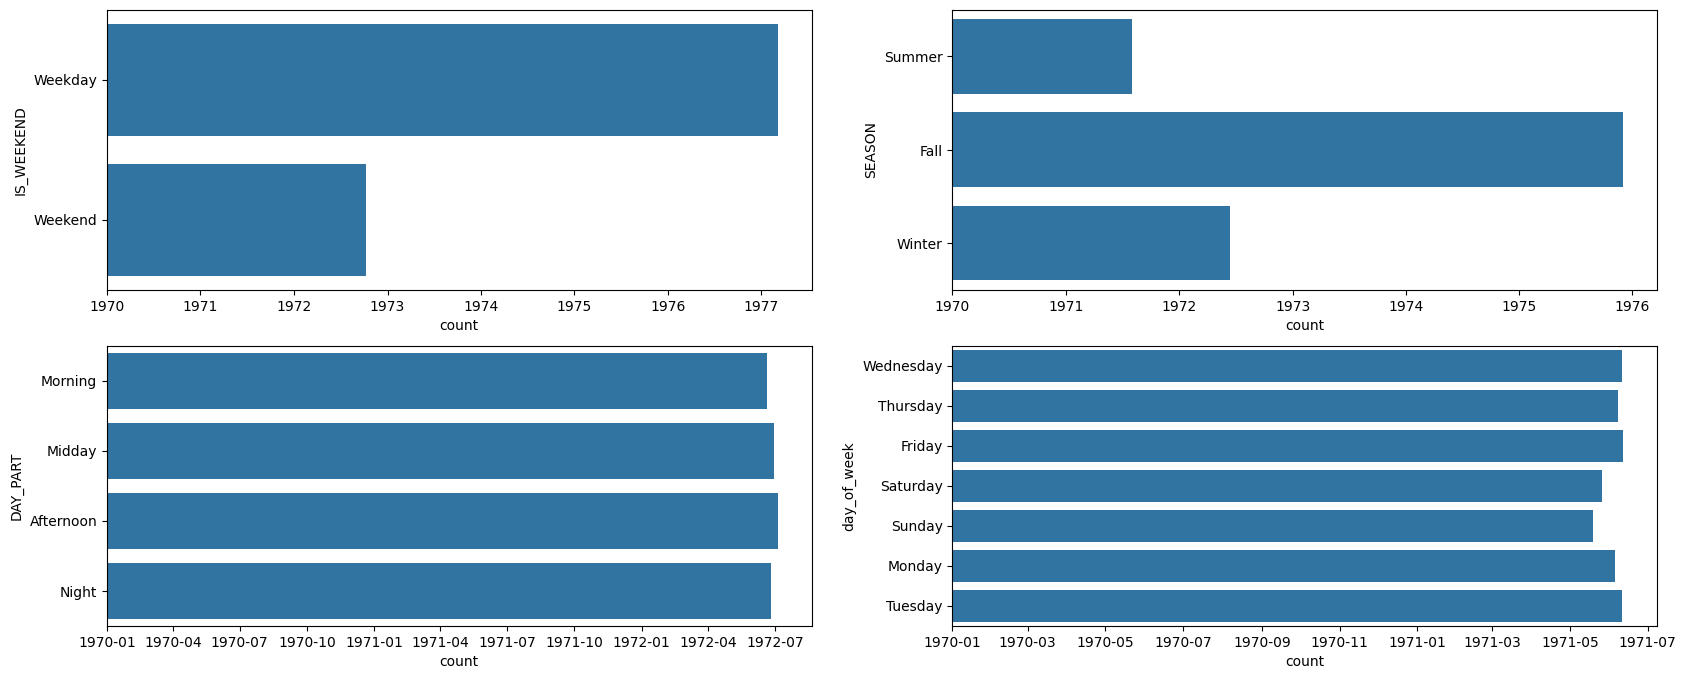

In [35]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.countplot(data['IS_WEEKEND'])
fig.add_subplot(2,2,2)
sns.countplot(data['SEASON'])
fig.add_subplot(2,2,3)
# sns.countplot(data['DAY_NIGHT'])
sns.countplot(data['DAY_PART'])
fig.add_subplot(2,2,4)
sns.countplot(data['day_of_week'])

**Univariate Analysis Summary**:
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation

In [36]:
# Prepare Features and Target
ws_sts_columns = [col for col in data.columns if 'WS' in col]
X = data[ws_sts_columns]
y = data['CF']

# Initialize lists to store the results
pearson_results = []
spearman_results = []

# Compute Pearson and Spearman correlations
for column in X.columns:
    if pd.api.types.is_numeric_dtype(X[column]):
        pearson_corr, _ = pearsonr(X[column], y)
        spearman_corr, _ = spearmanr(X[column], y)
        pearson_results.append({'WS_location': column, 'Pearson Correlation': pearson_corr})
        spearman_results.append({'WS_location': column, 'Spearman Correlation': spearman_corr})

# Convert the results to DataFrames
pearson_df = pd.DataFrame(pearson_results).sort_values(by='Pearson Correlation', ascending=False)
spearman_df = pd.DataFrame(spearman_results).sort_values(by='Spearman Correlation', ascending=False)

pearson_spearman = pd.merge(pearson_df, spearman_df, on='WS_location')

In [37]:
pearson_spearman

,WS_location,Pearson Correlation,Spearman Correlation
0,MEAN_WS,0.867128,0.884486
1,WS_2503597,0.848757,0.827564
2,P75_WS,0.845775,0.878471
3,MEDIAN_WS,0.842367,0.851489
4,WS_2508550,0.841939,0.840181
5,WS_2508545,0.840002,0.841517
6,WS_75936,0.839991,0.841491
7,WS_75935,0.837190,0.839795
8,WS_75934,0.834120,0.837020
9,WS_77363,0.833789,0.836939


# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation
- Categorical analysis

**ANOVA Test**

In [38]:
from scipy.stats import f_oneway, ttest_ind

class1= data[data['SEASON']=='Summer']['CF']
class2= data[data['SEASON']=='Fall']['CF']
class3= data[data['SEASON']=='Winter']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature SEASON:\n',f_oneway(class1, class2, class3))

This is the ANOVA-test result of feature SEASON:
 F_onewayResult(statistic=83.08876803021315, pvalue=5.202013210703249e-36)


The feature SEASON is correlated with the target value, indicating that the season significantly affects the electricity output.

In [39]:
class1= data[data['day_of_week']=='Monday']['CF']
class2= data[data['day_of_week']=='Tuesday']['CF']
class3= data[data['day_of_week']=='Wednesday']['CF']
class4= data[data['day_of_week']=='Thursday']['CF']
class5= data[data['day_of_week']=='Friday']['CF']
class6= data[data['day_of_week']=='Saturday']['CF']
class7= data[data['day_of_week']=='Sunday']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature day_of_week:\n',f_oneway(class1, class2, class3, class4, class5, class6, class7))

This is the ANOVA-test result of feature day_of_week:
 F_onewayResult(statistic=8.217475502611896, pvalue=7.45666768797419e-09)


The feature day_of_week is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [40]:
class1= data[data['DAY_PART']=='Morning']['CF']
class2= data[data['DAY_PART']=='Midday']['CF']
class3= data[data['DAY_PART']=='Afternoon']['CF']
class4= data[data['DAY_PART']=='Night']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature DAY_PART:\n',f_oneway(class1, class2, class3, class4))

This is the ANOVA-test result of feature DAY_PART:
 F_onewayResult(statistic=68.68120772570627, pvalue=3.393868596506757e-43)


The feature DAY_PART is correlated with the target value, indicating that the feature significantly affects the electricity output.

**T-test**

In [41]:
class1= data[data['DAY_NIGHT']=='Night']['CF']
class2= data[data['DAY_NIGHT']=='Daylight']['CF']


# Conduct the t-test
print('This is the T-test result of feature DAY_NIGHT:\n',ttest_ind(class1, class2))

This is the T-test result of feature DAY_NIGHT:
 TtestResult(statistic=13.82232140933804, pvalue=2.172226869557305e-42, df=3633.0)


The feature DAY_NIGHT is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [42]:
class1= data[data['IS_WEEKEND']=='Weekday']['CF']
class2= data[data['IS_WEEKEND']=='Weekend']['CF']


# Conduct the t-test
print('This is the T-test result of feature IS_WEEKEND:\n',ttest_ind(class1, class2))

This is the T-test result of feature IS_WEEKEND:
 TtestResult(statistic=1.3132394681703519, pvalue=0.1891852034969178, df=3633.0)


The feature IS_WEEKEND is not correlated with the target value, indicating that there is no significant difference between this feature.

<Axes: xlabel='day_of_week', ylabel='CF'>

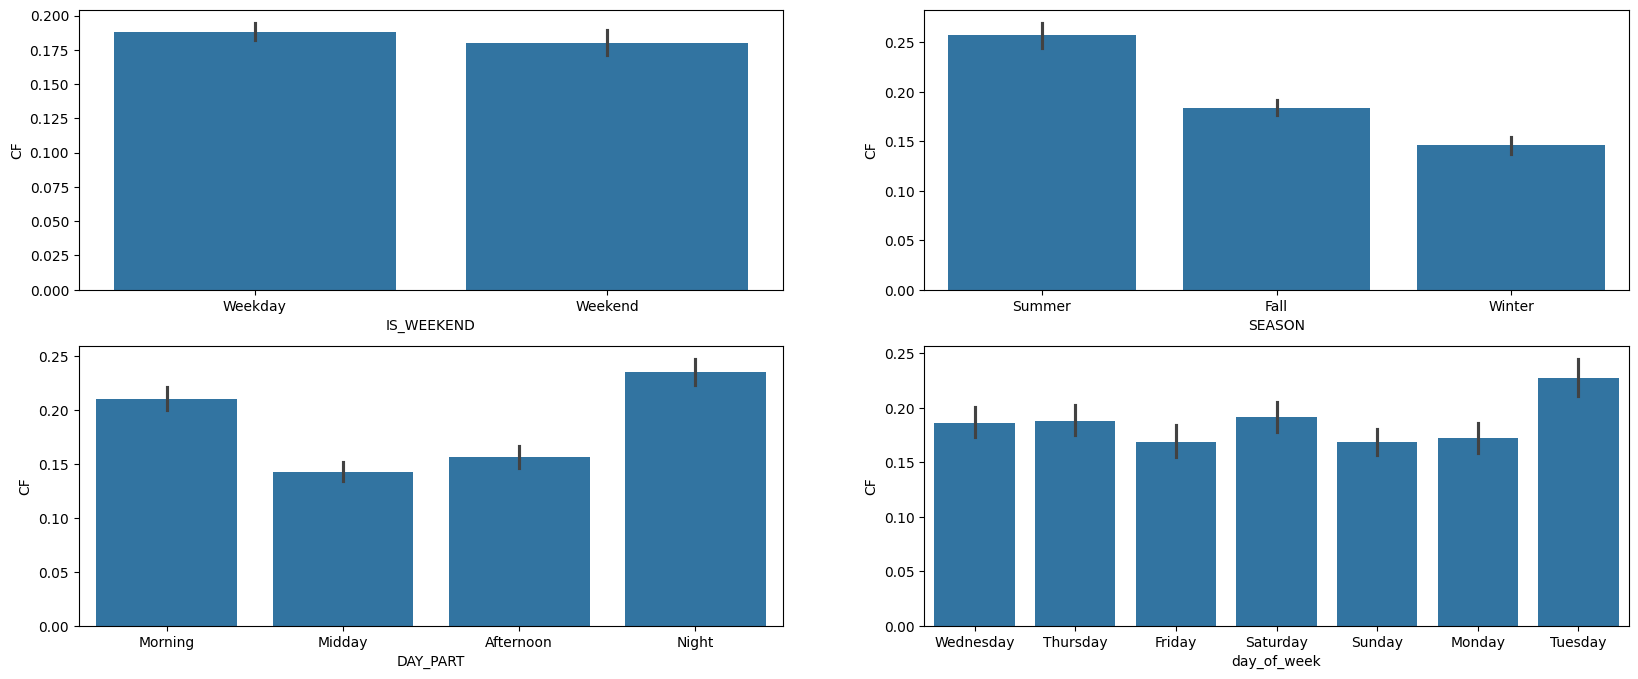

In [43]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.barplot(data, x='IS_WEEKEND', y='CF')
fig.add_subplot(2,2,2)
sns.barplot(data, x='SEASON', y='CF')
fig.add_subplot(2,2,3)
# sns.barplot(data, x='DAY_NIGHT', y='CF')
sns.barplot(data, x='DAY_PART', y='CF')
fig.add_subplot(2,2,4)
sns.barplot(data, x='day_of_week', y='CF')

The average value of CF varies across different SEASONS and dayparts.

The bar plot shows numerical values. Now here are distribution plot.

In [44]:
### function
def plot_distribution(data,feature_name, classifications_to_vis):
  """
  Plots the density distribution of the 'CF' feature for different classifications.

  Args:
      data (pd.DataFrame): The dataset containing the features.
      feature_name (str): The column name to group by for classifications (e.g., 'SEASON').
      classifications_to_vis (list): The list of classification values to visualize (e.g., ['Summer', 'Fall']).
  """
  plt.figure(figsize=(10, 3))
  for classification in classifications_to_vis:
      # Plot the density for the current classification group
      data[data[feature_name] == classification]['CF'].plot(kind='density', label=classification)

  plt.xlim(0, 1.3)
  plt.legend()
  plt.title(f'Distribution of CF for Different Classifications')
  plt.show()

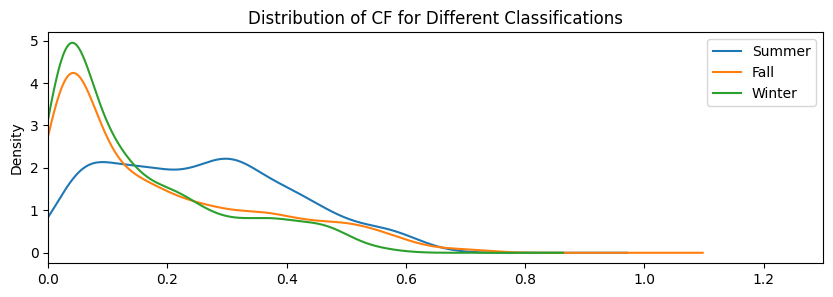

In [45]:
plot_distribution(data, 'SEASON', ['Summer', 'Fall', 'Winter'])

The bar plot only shows numerical values, but the distribution reveals that summer differs significantly from fall and winter.

This observation confirms our earlier hypothesis: we can create a new feature for temperature categorization.

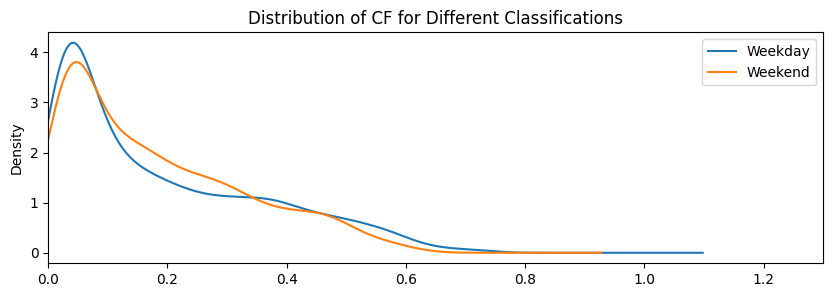

In [46]:
plot_distribution(data, 'IS_WEEKEND', ['Weekday', 'Weekend'])

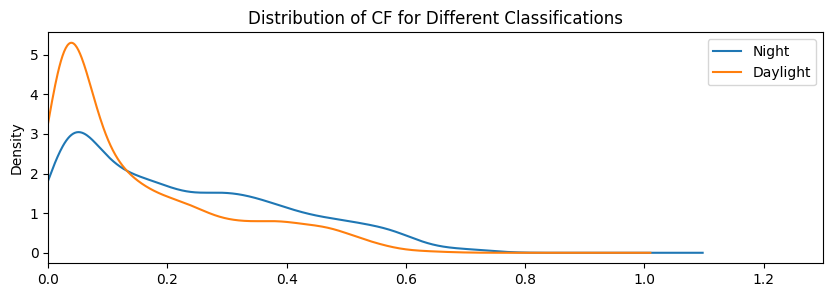

In [47]:
plot_distribution(data, 'DAY_NIGHT', ['Night', 'Daylight'])

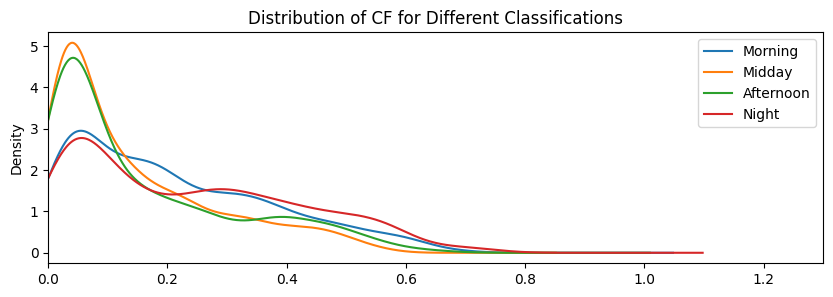

In [48]:
plot_distribution(data, 'DAY_PART', ['Morning', 'Midday', 'Afternoon', 'Night'])

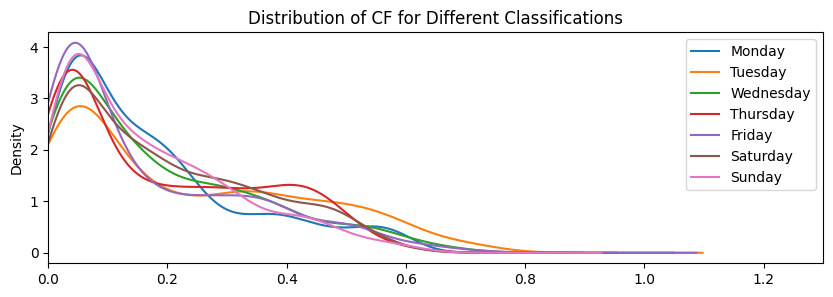

In [49]:
plot_distribution(data, 'day_of_week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'])

Now here is the time series of features and target with dual axes.

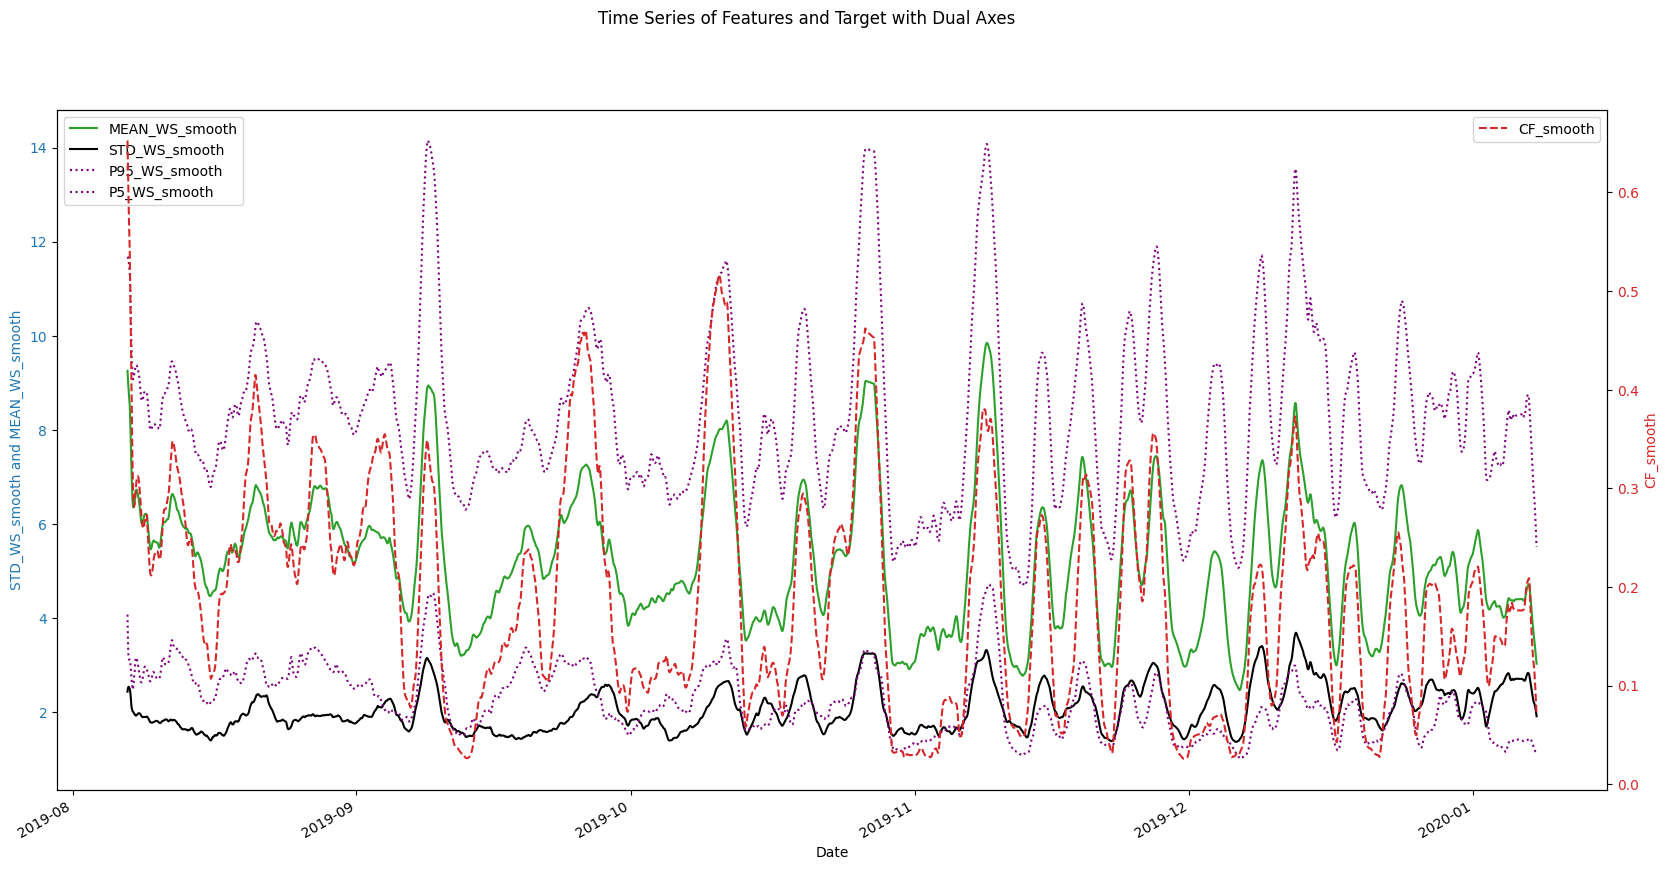

In [50]:
numerical_data = data.select_dtypes(include=[np.number])
numerical_data['CF_smooth'] = numerical_data['CF'].rolling(window=48, min_periods=1).mean()
numerical_data['MEAN_WS_smooth'] = numerical_data['MEAN_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['STD_WS_smooth'] = numerical_data['STD_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P95_WS_smooth'] = numerical_data['P95_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P5_WS_smooth'] = numerical_data['P5_WS'].rolling(window=48, min_periods=1).mean()

# Plot the data
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot STD_WS_smooth on ax1
numerical_data['MEAN_WS_smooth'].plot(ax=ax1,label='MEAN_WS_smooth', color='tab:green')
numerical_data['STD_WS_smooth'].plot(ax=ax1,label='STD_WS_smooth', color='black')
numerical_data['P95_WS_smooth'].plot(ax=ax1,label='P95_WS_smooth', color='purple', linestyle=':')
numerical_data['P5_WS_smooth'].plot(ax=ax1,label='P5_WS_smooth', color='purple', linestyle=':')

ax1.set_xlabel('Date')
ax1.set_ylabel('STD_WS_smooth and MEAN_WS_smooth', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()

# Plot CF on ax2
numerical_data['CF_smooth'].plot(ax=ax2,label='CF_smooth', color='tab:red', linestyle='--')
ax2.set_ylabel('CF_smooth', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add title and legend
fig.suptitle('Time Series of Features and Target with Dual Axes')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()

As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

The analysis reveals that:
- Wind speeds from previous time points influence the current wind speed.
- The current wind speed is strongly correlated with electricity output.

Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

# Feature Engineering & Part of EDA

In [51]:
def get_data_final(data, correlation):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:10]['WS_location'].to_list()
    data_final = data[high_cor_list].copy()

    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)

    data_final = pd.merge(data_final, data.select_dtypes(include='object'), left_index=True, right_index=True)
    data_final['CF'] = data['CF']
    cols = data_final.columns.tolist()
    new_order = [cols[-1]] + cols[:-1]
    data_final = data_final[new_order]

    return data_final

data_final = get_data_final(data, pearson_spearman)

In [52]:
predict_final = get_data_final(predict, pearson_spearman)

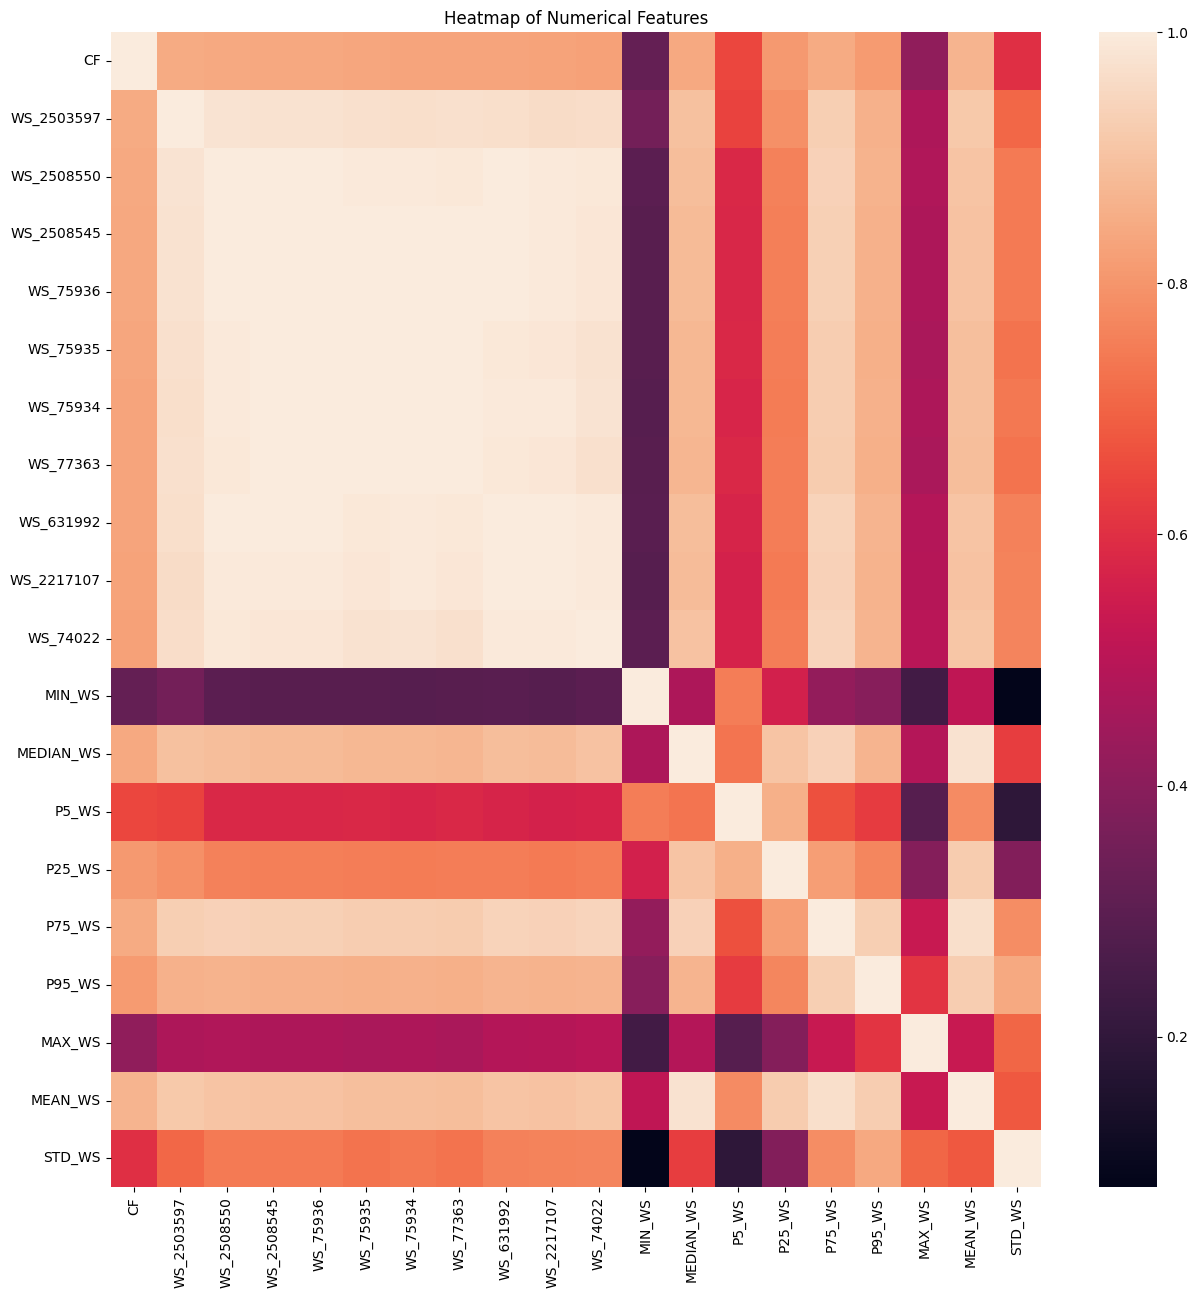

In [53]:
numerical_columns = data_final.select_dtypes(include=[np.number])
plt.figure(figsize=(15,15))
sns.heatmap(numerical_columns.corr())
plt.title('Heatmap of Numerical Features')
plt.show()

## Multivariate Analysis

### Linear Regression - Feature Selection

In [54]:
# Extract categorical features
categorical_features = data.select_dtypes('object').columns

In [55]:
formula= 'CF' + ' ~ C(SEASON) + C(DAY_NIGHT) + C(DAY_PART) + C(IS_WEEKEND) + C(day_of_week) + WS_2503597 + WS_2508550 + WS_2508545 + WS_75936 + WS_75935 + WS_75934 + WS_77363 + WS_631992 + WS_2217107 + WS_74022 + MEAN_WS + MEDIAN_WS + STD_WS + MIN_WS + MAX_WS + P5_WS + P25_WS + P75_WS + P95_WS'
mod = smf.ols(formula, data=data)
res = mod.fit()
print(res.summary())
print('---------------------------------------------------------------------------------------------------')
print('\t')

                            OLS Regression Results                            
Dep. Variable:                     CF   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     569.9
Date:                Tue, 25 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:39:50   Log-Likelihood:                 4566.4
No. Observations:                3635   AIC:                            -9071.
Df Residuals:                    3604   BIC:                            -8879.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

The IS_WEEKEND feature shows no significant differences in its impact on Y in univariate, bivariate, or multivariate analysis. Therefore, this feature has no predictive power and should be discarded.

This also indicates that these 9 key percentilesare likely to be statistically significant. This could imply that these measures are important in understanding the distribution and variability of the data, influencing decisions or insights derived from the analysis.

### Decision Tree - Feature Selection

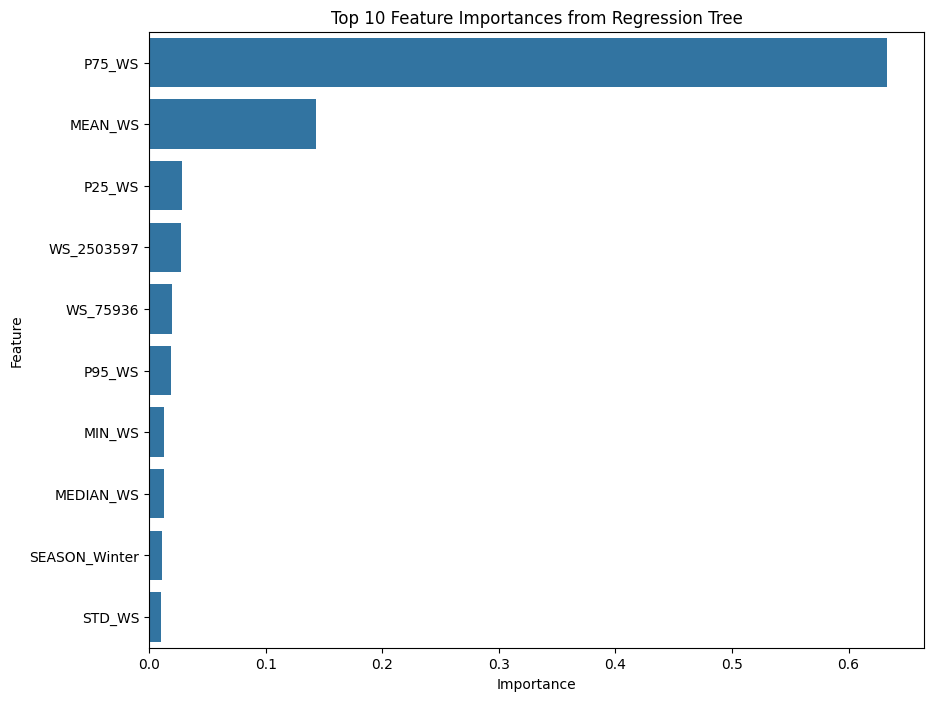

In [56]:
# Prepare Features and Target
X = data_final.drop(columns=['CF'])
y = data_final['CF']

# Identify categorical columns
categorical_columns = data_final.select_dtypes('object').columns.to_list()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()

# Define the preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Create a pipeline that first transforms the data and then fits the regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the model
pipeline.fit(X, y)

# Extract the trained regressor and the preprocessor
regressor = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']

preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Get the feature names after one-hot encoding
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = numerical_columns + encoded_feature_names.tolist()

# Get Feature Importances
importances = regressor.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot only the top N features
top_n = 10
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(top_n))
plt.title(f'Top {top_n} Feature Importances from Regression Tree')
plt.show()

Logically, we would expect that the average wind speed around the wind farm would have the most significant impact on electricity generation. However, the feature importance analysis indicates that the 75th percentile wind speed has a greater influence.

In [57]:
# Visualize the regression tree with a larger output size
dot_data = export_graphviz(regressor, out_file=None,
                           feature_names=all_feature_names,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('regression_tree')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.132637 to fit


'regression_tree.png'

I tried to visualize the regression tree, but it's too large to save. However, it showed these 24 features are equally important.

**Brief summary on Multivariate Analysis:**

Based on the coefficients from **OLS regression** and the feature importance from the **decision tree**, I explored both the linear and nonlinear relationships between features and the target value. This analysis allowed me to perform an initial feature selection.

In [58]:
data_final.drop(columns=['IS_WEEKEND'], inplace=True)

The feature engineering process is now complete, resulting in a total of **23 features**:

**Numerical Features (19 total)**:

These include the **10 features with the highest correlation to the target value** and **9 key percentiles** at each time point to represent the characteristics of the wind speed distribution.

- Reason for Selection: These features have a strong relationship with the target variable, indicated by their high correlation values.

**Categorical Features (4 total)**:

These features are: **SEASON, DAY_NIGHT, DAY_PART, day_of_week**.

These features were selected based on bar plots, density plots, ANOVA tests, and t-tests, all of which demonstrated their strong relationship with the target variable.

- Reason for Selection: These features exhibit high predictive power for the target variable.
The selected features are expected to provide robust inputs for the predictive model due to their strong associations with the target value.

Now I start modeling.

# Stratified Split by DAY_NIGHT

In [59]:
# Ensure the DataFrame is sorted by date
data.sort_index(inplace=True)

In [60]:
# Define the split ratios
train_ratio = 0.8
test_ratio = 0.2

def stratified_train_test_split(data, feature, train_ratio, test_ratio):
    # Create empty DataFrames for train and test sets
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each unique value in the feature column
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        train_subset, test_subset = train_test_split(subset, test_size=test_ratio, random_state=42)

        train_data = pd.concat([train_data, train_subset])
        test_data = pd.concat([test_data, test_subset])

    return train_data.sort_index(), test_data.sort_index()

# Perform the stratified train-test split
train_data, test_data = stratified_train_test_split(data_final, 'DAY_NIGHT', train_ratio, test_ratio)

## Strategy A - Autogluon

In [61]:
predictor = TabularPredictor(label='CF',
                             problem_type= 'regression',
                             eval_metric='mean_absolute_error',
                             learner_kwargs={'ignored_columns': []}).fit(
                                                                           train_data = train_data,
                                                                           time_limit=300,presets="medium_quality_faster_train")

No path specified. Models will be saved in: "AutogluonModels/ag-20240625_204020"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
Memory Avail:       10.87 GB / 12.67 GB (85.8%)
Disk Space Avail:   74.14 GB / 107.72 GB (68.8%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20240625_204020"
Train Data Rows:    2907
Train Data Columns: 23
Label Column:       CF
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11134.73 MB
	Train Data (Origin

[1000]	valid_set's l1: 0.0332332
[2000]	valid_set's l1: 0.032175
[3000]	valid_set's l1: 0.0319204
[4000]	valid_set's l1: 0.0317446
[5000]	valid_set's l1: 0.0317298
[6000]	valid_set's l1: 0.0316681
[7000]	valid_set's l1: 0.0316333
[8000]	valid_set's l1: 0.0315982
[9000]	valid_set's l1: 0.0315798
[10000]	valid_set's l1: 0.0315735


	-0.0316	 = Validation score   (-mean_absolute_error)
	14.35s	 = Training   runtime
	1.87s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 279.13s of the 279.12s of remaining time.


[1000]	valid_set's l1: 0.0365276
[2000]	valid_set's l1: 0.0363932


	-0.0364	 = Validation score   (-mean_absolute_error)
	6.2s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 272.39s of the 272.39s of remaining time.
	-0.0414	 = Validation score   (-mean_absolute_error)
	11.9s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 260.21s of the 260.21s of remaining time.
	Ran out of time, early stopping on iteration 9593.
	-0.0353	 = Validation score   (-mean_absolute_error)
	260.41s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.82s of the -0.33s of remaining time.
	Ensemble Weights: {'LightGBMXT': 0.833, 'KNeighborsDist': 0.083, 'LightGBM': 0.083}
	-0.0313	 = Validation score   (-mean_absolute_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 300.48s ... Best model: WeightedEnsemble_L2 | Estimated inference thr

In [62]:
leaderboard_df = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.031343,mean_absolute_error,2.061830,20.654353,0.001117,0.098289,2,True,7
1,LightGBMXT,-0.031572,mean_absolute_error,1.872217,14.345081,1.872217,14.345081,1,True,3
2,CatBoost,-0.035327,mean_absolute_error,0.014198,260.409123,0.014198,260.409123,1,True,6
3,LightGBM,-0.036387,mean_absolute_error,0.178673,6.197213,0.178673,6.197213,1,True,4
4,KNeighborsDist,-0.040686,mean_absolute_error,0.009822,0.013770,0.009822,0.013770,1,True,2
5,RandomForestMSE,-0.041425,mean_absolute_error,0.111478,11.899364,0.111478,11.899364,1,True,5
6,KNeighborsUnif,-0.042330,mean_absolute_error,0.036890,2.010564,0.036890,2.010564,1,True,1


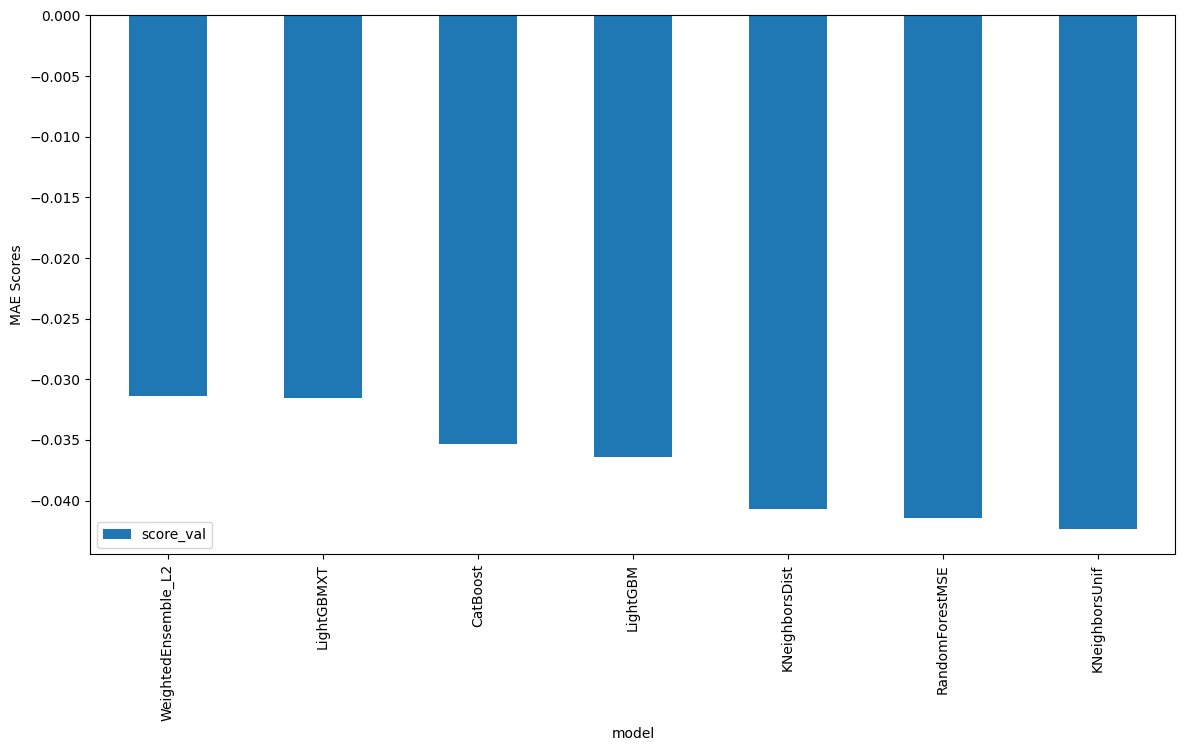

In [63]:
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("MAE Scores")
plt.show()

In [64]:
import autogluon.core as space
# from autogluon.core.searcher import Space
## From autogluon documentation
from autogluon.tabular import TabularPredictor, TabularDataset
import autogluon.common as ag


eval_metric = 'mean_absolute_error'
label = 'CF'
ignored_columns = []   # Ignored columns while training
train_data = train_data                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 300                             # 5 minutes -> 60*5 = 300 seconds
presets = "best_quality"


nn_options = {'num_epochs': 5,
              'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
                    # learning rate used in training (real-valued hyperparameter searched on log-scale)
              'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
                    # activation function used in NN (categorical hyperparameter, default = first entry)
              'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)}

gbm_options = [{'extra_trees': True,
                'num_boost_round': ag.space.Int(lower=100, upper=500, default=100),
                'num_leaves': ag.space.Int(lower=25, upper=64, default=36),
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']



hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,
                  }

num_trials = 20            # Number of hyperparameter optimization trials you want to perform
search_strategy = 'auto'  # tune hyperparameters using Bayesian optimization routine with a local scheduler
scheduler = 'local'       # Local FIFO scheduler
hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(label='CF', problem_type='regression', eval_metric='mean_absolute_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train_data,
                                                                         time_limit=time_limit,
                                                                         presets=presets,
                                                                         hyperparameters=hyperparameters,
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         refit_full='best')

No path specified. Models will be saved in: "AutogluonModels/ag-20240625_204521"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
Memory Avail:       10.53 GB / 12.67 GB (83.1%)
Disk Space Avail:   74.03 GB / 107.72 GB (68.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be

(_dystack pid=11871) ╭──────────────────────────────────────────────────────────╮
(_dystack pid=11871) │ Configuration for experiment     NeuralNetTorch_BAG_L1   │
(_dystack pid=11871) ├──────────────────────────────────────────────────────────┤
(_dystack pid=11871) │ Search algorithm                 SearchGenerator         │
(_dystack pid=11871) │ Scheduler                        FIFOScheduler           │
(_dystack pid=11871) │ Number of trials                 20                      │
(_dystack pid=11871) ╰──────────────────────────────────────────────────────────╯
(_dystack pid=11871) 
(_dystack pid=11871) View detailed results here: /content/AutogluonModels/ag-20240625_204521/ds_sub_fit/sub_fit_ho/models/NeuralNetTorch_BAG_L1


(_dystack pid=11871) Reached timeout of 10.17185650306642 seconds. Stopping all trials.
(_dystack pid=11871) Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
(_dystack pid=11871) You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
(_dystack pid=11871) You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
(_dystack pid=11871) Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20240625_204521/ds_sub_fit/sub_fit_ho/models/NeuralNetTorch_BAG_L1' in 0.0278s.


(_dystack pid=11871) 


(_dystack pid=11871) Failed to fetch metrics for 2 trial(s):
(_dystack pid=11871) - c23cd09b: FileNotFoundError('Could not fetch metrics for c23cd09b: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20240625_204521/ds_sub_fit/sub_fit_ho/models/NeuralNetTorch_BAG_L1/c23cd09b')
(_dystack pid=11871) - f635b49e: FileNotFoundError('Could not fetch metrics for f635b49e: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20240625_204521/ds_sub_fit/sub_fit_ho/models/NeuralNetTorch_BAG_L1/f635b49e')
(_dystack pid=11871) No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L1... Skipping this model.
(_dystack pid=11871) Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 10.17s of the -20.63s of remaining time.
(_dystack pid=11871) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.21%)
(model_trial pid=12772) Unhandled error (supp

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.08%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	-0.0399	 = Validation score   (-mean_absolute_error)
	30.91s	 = Training   runtime
	0.11s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up to 22.17s of the 116.76s of remaining time.


  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.07%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-0.0348	 = Validation score   (-mean_absolute_error)
	48.36s	 = Training   runtime
	0.63s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 22.17s of the 68.24s of remaining time.
2024-06-25 20:49:13,760	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_BAG_L1   |
+----------------------------------------------------------+
| Search algorithm                 SearchGenerator         |
| Scheduler                        FIFOScheduler           |
| Number of trials                 20                      |
+----------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20240625_204521/models/NeuralNetTorch_BAG_L1


2024-06-25 20:49:36,170	INFO timeout.py:54 -- Reached timeout of 22.17177766380608 seconds. Stopping all trials.
2024-06-25 20:49:36,191	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-06-25 20:49:36,197	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20240625_204521/models/NeuralNetTorch_BAG_L1' in 0.0175s.
2024-06-25 20:49:39,002	WARNING experiment_analysis.py:190 -- Failed to fetch metrics for 2 trial(

	-0.0361	 = Validation score   (-mean_absolute_error)
	46.43s	 = Training   runtime
	0.44s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 147.85s of the -9.41s of remaining time.
	Ensemble Weights: {'LightGBM_BAG_L1/T1': 0.733, 'LightGBMLarge_BAG_L1': 0.267}
	-0.0346	 = Validation score   (-mean_absolute_error)
	0.06s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 4 L2 models ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 147.85s of the -9.54s of remaining time.
	Ensemble Weights: {'LightGBM_BAG_L1/T1': 0.733, 'LightGBMLarge_BAG_L1': 0.267}
	-0.0346	 = Validation score   (-mean_absolute_error)
	0.06s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 157.8s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 341.9 rows/s (364 batch size)
Automatically performing refit_full as a post-fit operation (due to `.fit(..., refit_full=True)`
Refitting models via `

In [65]:
leaderboard_df = pd.DataFrame(predictor_new_hpo.leaderboard(silent=True))
leaderboard_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.034557,mean_absolute_error,1.065604,94.852904,0.001260,0.063778,2,True,4
1,WeightedEnsemble_L3,-0.034557,mean_absolute_error,1.066212,94.853756,0.001868,0.064630,3,True,5
2,LightGBM_BAG_L1/T1,-0.034755,mean_absolute_error,0.628901,48.360011,0.628901,48.360011,1,True,2
3,LightGBMLarge_BAG_L1,-0.036140,mean_absolute_error,0.435444,46.429115,0.435444,46.429115,1,True,3
4,LightGBMXT_BAG_L1/T1,-0.039854,mean_absolute_error,0.108046,30.914733,0.108046,30.914733,1,True,1
5,WeightedEnsemble_L2_FULL,NaN,mean_absolute_error,NaN,8.487815,NaN,0.063778,2,True,8
6,LightGBM_BAG_L1/T1_FULL,NaN,mean_absolute_error,NaN,4.374011,NaN,4.374011,1,True,6
7,LightGBMLarge_BAG_L1_FULL,NaN,mean_absolute_error,NaN,4.050026,NaN,4.050026,1,True,7


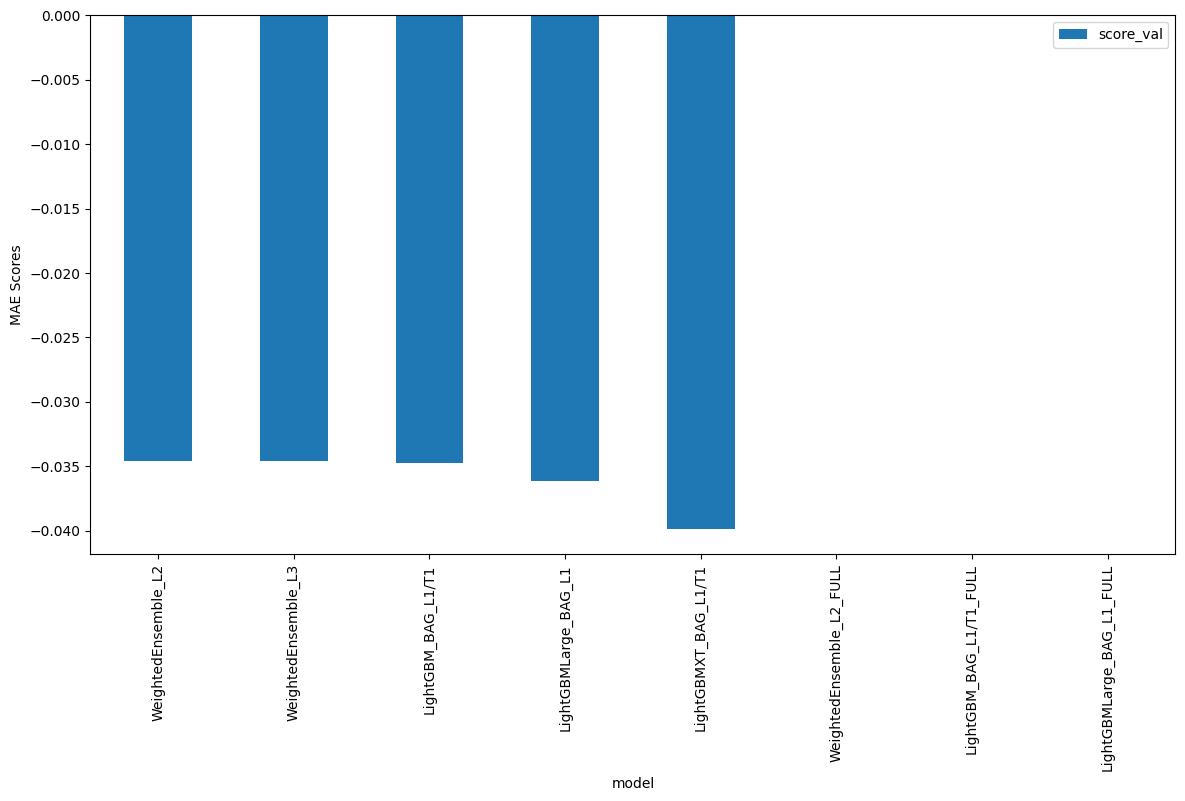

In [66]:
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("MAE Scores")
plt.show()

In [67]:
predictions = predictor_new_hpo.predict(test_data)
predictions.reset_index()

,DATETIME,CF
0,2019-08-08 17:00:00,0.260972
1,2019-08-09 03:00:00,0.236155
2,2019-08-09 11:00:00,0.041703
3,2019-08-09 12:00:00,0.030105
4,2019-08-09 14:00:00,0.102243
...,...,...
723,2020-01-07 06:00:00,0.032716
724,2020-01-07 07:00:00,0.035445
725,2020-01-07 09:00:00,0.038102
726,2020-01-07 11:00:00,0.022156


In [68]:
mean_absolute_error(test_data['CF'], predictions)

0.035656709820496436

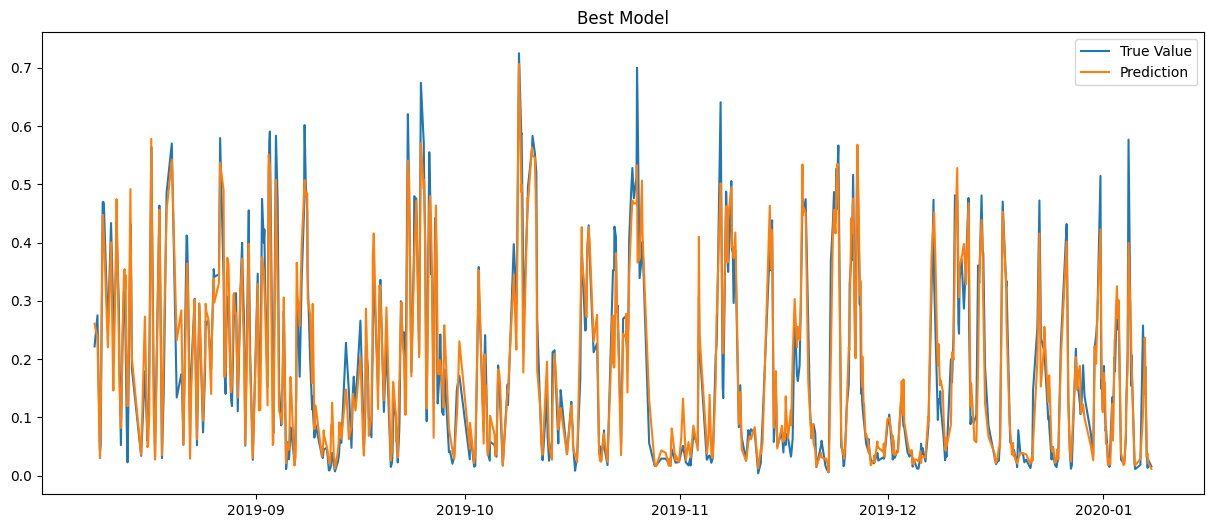

In [69]:
plt.figure(figsize=(15,6))
plt.title('Best Model')
plt.plot(test_data['CF'], label='True Value')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [70]:
best_model = predictor_new_hpo.get_model_best()
print("Best model:", best_model)

Best model: WeightedEnsemble_L2


<ipython-input-70-2f3c693cf1ae>:1: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor_new_hpo.get_model_best()


In [71]:
predictions_best_model = predictor_new_hpo.predict(test_data, model=best_model)

In [72]:
mean_absolute_error(test_data['CF'], predictions_best_model)

0.035656709820496436

In [73]:
feature_importance = predictor_new_hpo.feature_importance(train_data)
print(feature_importance)

Computing feature importance via permutation shuffling for 23 features using 2907 rows with 5 shuffle sets...
	472.57s	= Expected runtime (94.51s per shuffle set)
	438.78s	= Actual runtime (Completed 5 of 5 shuffle sets)


             importance    stddev       p_value  n  p99_high   p99_low
P75_WS         0.055925  0.001140  2.068028e-08  5  0.058271  0.053578
MEAN_WS        0.037795  0.000512  4.043556e-09  5  0.038849  0.036740
P95_WS         0.020235  0.000416  2.143370e-08  5  0.021092  0.019379
P25_WS         0.017542  0.000193  1.765011e-09  5  0.017940  0.017144
WS_2503597     0.014884  0.000210  4.725326e-09  5  0.015316  0.014452
WS_2508550     0.014098  0.000285  2.009529e-08  5  0.014686  0.013511
day_of_week    0.010155  0.000227  3.004901e-08  5  0.010623  0.009687
SEASON         0.009856  0.000317  1.290159e-07  5  0.010509  0.009202
MAX_WS         0.009515  0.000236  4.554117e-08  5  0.010001  0.009028
MIN_WS         0.009431  0.000240  5.034027e-08  5  0.009926  0.008937
MEDIAN_WS      0.008150  0.000159  1.759142e-08  5  0.008479  0.007822
WS_74022       0.007817  0.000100  3.184196e-09  5  0.008023  0.007612
STD_WS         0.007591  0.000178  3.637693e-08  5  0.007958  0.007224
WS_250

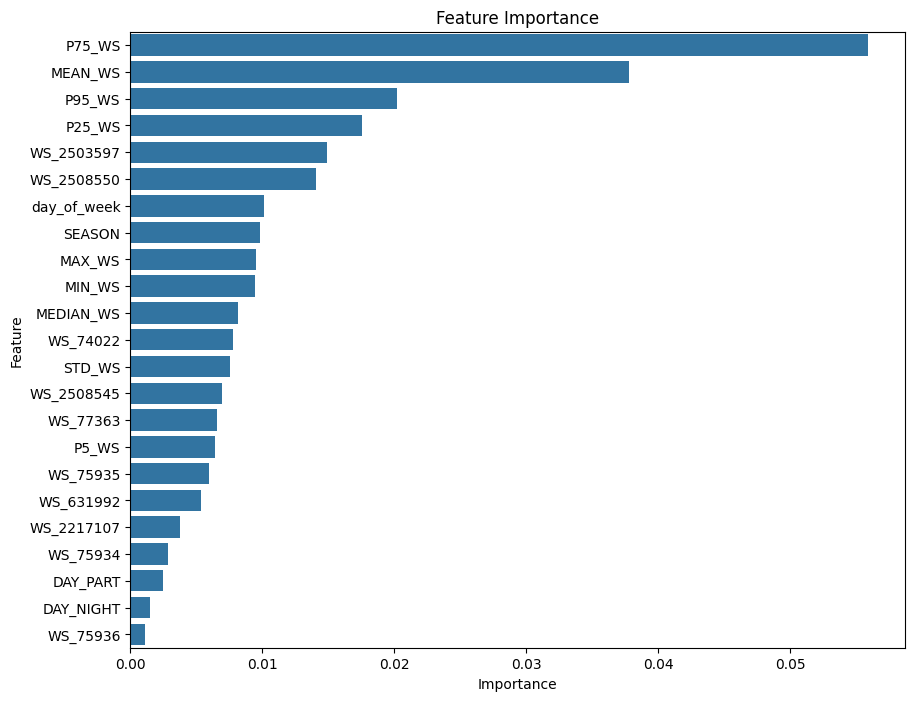

In [74]:
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance['importance'], y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [75]:
predictions_predict = predictor_new_hpo.predict(predict_final)


In [76]:
final_result = predictions_predict.reset_index()
# final_result.to_csv('final.csv')
final_result

,DATETIME,CF
0,2020-01-09 00:00:00,0.013634
1,2020-01-09 01:00:00,0.021021
2,2020-01-09 02:00:00,0.026719
3,2020-01-09 03:00:00,0.031506
4,2020-01-09 04:00:00,0.043532
5,2020-01-09 05:00:00,0.034547
6,2020-01-09 06:00:00,0.061893
7,2020-01-09 07:00:00,0.100344
8,2020-01-09 08:00:00,0.126589
9,2020-01-09 09:00:00,0.090064


# LSTM

## Model Training

In [77]:
def generate_dataset_LSTM(data, rolling_window=1):
  """
  Generates a new dataset with rolling averages for LSTM input.

  Args:
      data (pd.DataFrame): The original dataset containing the features.
      rolling_window (int): The size of the rolling window. Default is 1.

  Returns:
      pd.DataFrame: The new dataset with rolling averages and the 'CF' feature.
  """
  new_dataset = pd.DataFrame()
  new_dataset['MEAN_WS_ROLLING_AVG'] = data['MEAN_WS'].shift().rolling(rolling_window, min_periods=1).mean() # 选3的原因：认为前2个小时包括当前，可能会造成影响。最后也可以用sensitivity analysis选几
  new_dataset['STD_WS_ROLLING_AVG'] = data['STD_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  new_dataset['P5_WS_ROLLING_AVG'] = data['P5_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  new_dataset['P95_WS_ROLLING_AVG'] = data['P95_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  new_dataset['CF'] = data['CF']
  new_dataset = new_dataset.dropna()
  return new_dataset

In [78]:
dataB = generate_dataset_LSTM(data)
dataB

,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,CF
DATETIME,,,,,
2019-08-07 01:00:00,9.254286,2.437052,4.0750,11.6790,0.605852
2019-08-07 02:00:00,8.919286,2.564288,3.1000,11.6590,0.564094
2019-08-07 03:00:00,8.690000,2.583354,2.6310,11.5625,0.532721
2019-08-07 04:00:00,8.560893,2.585717,2.7930,11.5725,0.495608
2019-08-07 06:00:00,8.165714,2.487341,2.9725,11.0715,0.384439
...,...,...,...,...,...
2020-01-07 19:00:00,2.037500,1.284776,0.8500,3.4040,0.004494
2020-01-07 20:00:00,1.923393,1.208378,1.0300,3.0835,0.006143
2020-01-07 21:00:00,1.789732,1.197688,0.8665,3.0785,0.008399


## Train Test Split by Time Order

In [79]:
test_split=round(len(dataB)*0.20)
test_split

727

In [80]:
df_for_training=dataB[:-test_split]
df_for_testing=dataB[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(2907, 5)
(727, 5)


## Data Scaling

In [81]:
from sklearn.preprocessing import MinMaxScaler

In [82]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.70534727, 0.40780138, 0.49270124, 0.53572527, 0.82554733],
       [0.67484717, 0.43703453, 0.35715279, 0.53460667, 0.76831153],
       [0.65397184, 0.44141511, 0.29195051, 0.52920943, 0.72530971],
       ...,
       [0.65787377, 0.64971348, 0.39156124, 0.60770715, 0.3310033 ],
       [0.66630357, 0.67935741, 0.31342972, 0.6262759 , 0.31736914],
       [0.65549197, 0.69158912, 0.25941888, 0.62482172, 0.29879807]])

## Training Data Preparation for LSTM

In [83]:
def createXY(dataset,n_past):
    """
    Create input sequences and target values for LSTM training.

    Args:
        dataset (np.ndarray): The scaled dataset from which to create sequences.
        n_past (int): The number of past time steps to use as input features.

    Returns:
        tuple: Two numpy arrays, dataX and dataY, where dataX contains input sequences and dataY contains target values.
    """
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled, 30)
testX,testY=createXY(df_for_testing_scaled, 30)


In [84]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (2877, 30, 5)
trainY Shape--  (2877,)


In [85]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (697, 30, 5)
testY Shape--  (697,)


In [86]:
print(testX)

[[[6.42583079e-01 6.72188453e-01 2.46837203e-01 6.15621242e-01
   2.96237341e-01]
  [6.44590948e-01 6.65441969e-01 2.68942027e-01 6.10979054e-01
   2.69845664e-01]
  [6.33559862e-01 6.41704910e-01 1.75309329e-01 5.99177829e-01
   2.44123007e-01]
  ...
  [2.68924368e-01 3.69588482e-01 1.20394828e-01 2.86137756e-01
   4.99227167e-02]
  [2.61470053e-01 3.74934104e-01 8.41095510e-02 2.83061607e-01
   4.43398620e-02]
  [2.49211485e-01 3.62673239e-01 8.79327124e-02 2.64800470e-01
   3.97259326e-02]]

 [[6.44590948e-01 6.65441969e-01 2.68942027e-01 6.10979054e-01
   2.69845664e-01]
  [6.33559862e-01 6.41704910e-01 1.75309329e-01 5.99177829e-01
   2.44123007e-01]
  [6.17610717e-01 6.13114990e-01 1.68358126e-01 5.83769121e-01
   1.84741735e-01]
  ...
  [2.61470053e-01 3.74934104e-01 8.41095510e-02 2.83061607e-01
   4.43398620e-02]
  [2.49211485e-01 3.62673239e-01 8.79327124e-02 2.64800470e-01
   3.97259326e-02]
  [2.37066723e-01 3.43180327e-01 6.33254553e-02 2.37478677e-01
   3.14669989e-02]]



In [87]:
# # To make the package version consistant if I have more time, it's better to use container
# !pip install keras==2.12.0
# !pip install tensorflow==2.10.1

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

## LSTM Model Configuration

In [89]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

<ipython-input-89-a9bea9d2a1d8>:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


## Model Training with Grid Search

In [90]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/8
90/90 [==============================] - 11s 53ms/step - loss: 0.0224 - val_loss: 0.0097
Epoch 2/8
90/90 [==============================] - 4s 41ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 3/8
90/90 [==============================] - 5s 61ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 4/8
90/90 [==============================] - 4s 42ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 5/8
90/90 [==============================] - 4s 40ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 6/8
90/90 [==============================] - 4s 44ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 7/8
90/90 [==============================] - 5s 59ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 8/8
90/90 [==============================] - 1s 10ms/step - loss: 0.0033
Epoch 1/8
90/90 [==============================] - 11s 72ms/step - loss: 0.0165 - val_loss: 0.0148
Epoch 2/8
90/90 [==============================] - 4s 40ms/step - loss: 0.0065 - val_loss: 0.0091
Epoch 3/8
90/90 [====================

In [91]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [92]:
my_model=grid_search.best_estimator_.model

## Model Prediction

In [93]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

22/22 [==============================] - 2s 17ms/step
prediction
 [[0.21280001]
 [0.20118195]
 [0.21472849]
 [0.22221678]
 [0.22736105]
 [0.22940654]
 [0.19564551]
 [0.18607232]
 [0.1860296 ]
 [0.18644167]
 [0.19356494]
 [0.18006967]
 [0.15874445]
 [0.13083929]
 [0.09146664]
 [0.07648903]
 [0.1144757 ]
 [0.1746582 ]
 [0.20316258]
 [0.18941295]
 [0.17946371]
 [0.21224955]
 [0.25365305]
 [0.29874542]
 [0.350205  ]
 [0.3688814 ]
 [0.3646436 ]
 [0.36530754]
 [0.3677478 ]
 [0.38221246]
 [0.35941014]
 [0.35580674]
 [0.41459575]
 [0.50046057]
 [0.57388407]
 [0.61589503]
 [0.65548414]
 [0.6543872 ]
 [0.73491836]
 [0.72403836]
 [0.72912157]
 [0.75257957]
 [0.74596584]
 [0.7038386 ]
 [0.6690362 ]
 [0.63213223]
 [0.6309461 ]
 [0.58512706]
 [0.5299372 ]
 [0.5133525 ]
 [0.52726614]
 [0.51048076]
 [0.46919656]
 [0.3806684 ]
 [0.3554394 ]
 [0.36586562]
 [0.3881135 ]
 [0.48334494]
 [0.52623105]
 [0.52958673]
 [0.49199313]
 [0.5107818 ]
 [0.55915546]
 [0.5709857 ]
 [0.6094844 ]
 [0.6028439 ]
 [0.524239

In [94]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [95]:
prediction_copies_array

array([[0.21280001, 0.21280001, 0.21280001, 0.21280001, 0.21280001],
       [0.20118195, 0.20118195, 0.20118195, 0.20118195, 0.20118195],
       [0.21472849, 0.21472849, 0.21472849, 0.21472849, 0.21472849],
       ...,
       [0.04622938, 0.04622938, 0.04622938, 0.04622938, 0.04622938],
       [0.03586104, 0.03586104, 0.03586104, 0.03586104, 0.03586104],
       [0.03629124, 0.03629124, 0.03629124, 0.03629124, 0.03629124]],
      dtype=float32)

In [96]:
prediction_copies_array.shape

(697, 5)

In [97]:
pred=np.reshape(prediction_copies_array,(len(prediction),5))[:,0]

In [98]:
pred.shape

(697,)

In [99]:
original_copies_array = np.repeat(testY,5, axis=-1)
# original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]
original=np.reshape(original_copies_array,(len(testY),5))[:,0]

In [100]:
pred.shape, original.shape

((697,), (697,))

In [101]:
# pred = prediction_copies_array
# original = np.repeat(testY,5, axis=-1)
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [0.21280001 0.20118195 0.21472849 0.22221678 0.22736105 0.22940654
 0.19564551 0.18607232 0.1860296  0.18644167 0.19356494 0.18006967
 0.15874445 0.13083929 0.09146664 0.07648903 0.1144757  0.1746582
 0.20316258 0.18941295 0.17946371 0.21224955 0.25365305 0.29874542
 0.350205   0.3688814  0.3646436  0.36530754 0.3677478  0.38221246
 0.35941014 0.35580674 0.41459575 0.50046057 0.57388407 0.61589503
 0.65548414 0.6543872  0.73491836 0.72403836 0.72912157 0.75257957
 0.74596584 0.7038386  0.6690362  0.63213223 0.6309461  0.58512706
 0.5299372  0.5133525  0.52726614 0.51048076 0.46919656 0.3806684
 0.3554394  0.36586562 0.3881135  0.48334494 0.52623105 0.52958673
 0.49199313 0.5107818  0.55915546 0.5709857  0.6094844  0.6028439
 0.52423906 0.49967343 0.47382957 0.4656806  0.47232687 0.49260345
 0.53710216 0.58350515 0.6741097  0.7880109  0.81053185 0.86386204
 0.8515701  0.9296926  0.9246438  0.8156477  0.76404035 0.6712383
 0.53869313 0.41000468 0.27921835 0.19784617 0.1711

In [102]:
len(pred), len(original)

(697, 697)

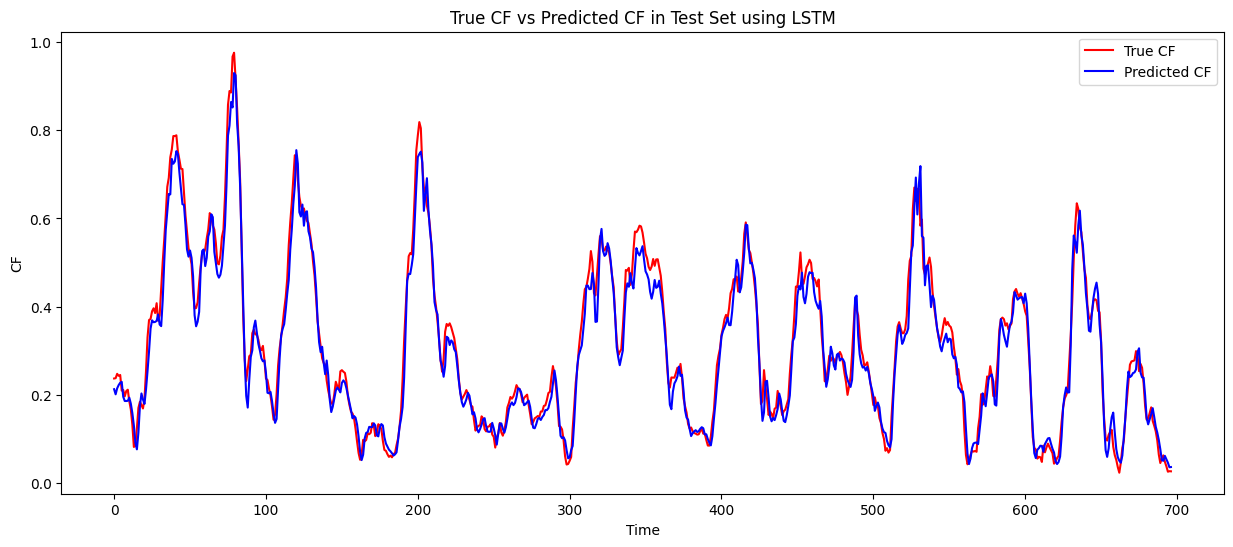

In [103]:
plt.figure(figsize=(15,6))
plt.plot(original, color = 'red', label = 'True CF')
plt.plot(pred, color = 'blue', label = 'Predicted CF')
plt.title('True CF vs Predicted CF in Test Set using LSTM')
plt.xlabel('Time')
plt.ylabel('CF')
plt.legend()
plt.show()

In [104]:
results_df = pd.DataFrame({
    'pred': pred,
    'original': original
})

In [105]:
results_df

,pred,original
0,0.212800,0.237067
1,0.201182,0.237774
2,0.214728,0.247634
3,0.222217,0.243123
4,0.227361,0.245001
...,...,...
692,0.061675,0.048295
693,0.054047,0.037906
694,0.046229,0.025736
695,0.035861,0.026923


In [106]:
mean_absolute_error(results_df['pred'], results_df['original'])

0.025735189525041183

### Prediction for Unseen Data

In [107]:
def get_data_final(data):

  ws_columns = [col for col in data.columns if col.startswith('WS_')]
  data_final = data.copy()
  data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
  data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
  data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
  data_final['STD_WS'] = data[ws_columns].std(axis=1)
  data_final['CF'] = data['CF']
  rolling_window = 1

  data_final['MEAN_WS_ROLLING_AVG'] = data_final['MEAN_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['STD_WS_ROLLING_AVG'] = data_final['STD_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P5_WS_ROLLING_AVG'] = data_final['P5_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P95_WS_ROLLING_AVG'] = data_final['P95_WS'].shift().rolling(rolling_window, min_periods=1).mean()

  data_final=data_final[['MEAN_WS_ROLLING_AVG','STD_WS_ROLLING_AVG','P5_WS_ROLLING_AVG','P95_WS_ROLLING_AVG','CF']]
  return data_final

final_past2 = get_data_final(data)
final_past2

,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,CF
DATETIME,,,,,
2019-08-07 00:00:00,NaN,NaN,NaN,NaN,0.652524
2019-08-07 01:00:00,9.254286,2.437052,4.0750,11.6790,0.605852
2019-08-07 02:00:00,8.919286,2.564288,3.1000,11.6590,0.564094
2019-08-07 03:00:00,8.690000,2.583354,2.6310,11.5625,0.532721
2019-08-07 04:00:00,8.560893,2.585717,2.7930,11.5725,0.495608
...,...,...,...,...,...
2020-01-07 19:00:00,2.037500,1.284776,0.8500,3.4040,0.004494
2020-01-07 20:00:00,1.923393,1.208378,1.0300,3.0835,0.006143
2020-01-07 21:00:00,1.789732,1.197688,0.8665,3.0785,0.008399


In [108]:
def get_data_final(data):
  ws_columns = [col for col in data.columns if col.startswith('WS_')]
  data_final = data.copy()

  data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
  data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
  data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
  data_final['STD_WS'] = data[ws_columns].std(axis=1)
  # data_final['DATETIME']=data['DATETIME']
  # data_final = pd.merge(data_final, data.select_dtypes(include='object'), left_index=True, right_index=True)
  data_final['CF'] = data['CF']
  #cols = data_final.columns.tolist()
  #new_order = [cols[-1]] + cols[:-1]
  #data_final = data_final[new_order]
  rolling_window = 1

  data_final['MEAN_WS_ROLLING_AVG'] = data_final['MEAN_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['STD_WS_ROLLING_AVG'] = data_final['STD_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P5_WS_ROLLING_AVG'] = data_final['P5_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P95_WS_ROLLING_AVG'] = data_final['P95_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final=data_final[['MEAN_WS_ROLLING_AVG','STD_WS_ROLLING_AVG','P5_WS_ROLLING_AVG','P95_WS_ROLLING_AVG','CF']]

  return data_final

df_30_days_future = get_data_final(predict)
#df_30_days_future.set_index('DATETIME', inplace=True)
df_30_days_future

,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,CF
DATETIME,,,,,
2020-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN
2020-01-09 01:00:00,1.765982,1.216290,0.9300,3.1800,NaN
2020-01-09 02:00:00,1.895000,1.358101,0.8765,4.6650,NaN
2020-01-09 03:00:00,2.066429,1.425932,0.8710,5.2150,NaN
2020-01-09 04:00:00,2.300089,1.359500,0.8900,5.3050,NaN
2020-01-09 05:00:00,2.538661,1.428709,0.9200,5.3645,NaN
2020-01-09 06:00:00,2.978750,1.199287,1.1585,4.5045,NaN
2020-01-09 07:00:00,3.530536,1.857366,1.1900,6.1200,NaN
2020-01-09 08:00:00,4.004196,2.413177,1.5865,7.6290,NaN


In [109]:
df_30_days_past=final_past2.iloc[-30:,:]
df_30_days_past.tail()

,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,CF
DATETIME,,,,,
2020-01-07 19:00:00,2.037500,1.284776,0.8500,3.4040,0.004494
2020-01-07 20:00:00,1.923393,1.208378,1.0300,3.0835,0.006143
2020-01-07 21:00:00,1.789732,1.197688,0.8665,3.0785,0.008399
2020-01-07 22:00:00,1.802768,1.175470,0.9920,2.9185,0.015788
2020-01-07 23:00:00,1.799286,1.131968,0.8455,2.7370,0.011883


In [110]:
df_30_days_future["CF"]=0
df_30_days_future=df_30_days_future[['MEAN_WS_ROLLING_AVG','STD_WS_ROLLING_AVG','P5_WS_ROLLING_AVG','P95_WS_ROLLING_AVG','CF']]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,4]=np.nan
pd.DataFrame(new_scaled_array)



,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,0.023574,0.127325,0.055471,0.060376,NaN
2,0.035321,0.159907,0.048033,0.143432,NaN
3,0.050928,0.175492,0.047268,0.174194,NaN
4,0.072202,0.160228,0.049910,0.179228,NaN
5,0.093923,0.176130,0.054080,0.182555,NaN
6,0.133991,0.123419,0.087238,0.134456,NaN
7,0.184228,0.274616,0.091617,0.224811,NaN
8,0.227353,0.402316,0.146740,0.309209,NaN
9,0.223979,0.455257,0.092521,0.327917,NaN


In [111]:
full_df=pd.concat([pd.DataFrame(old_scaled_array),pd.DataFrame(new_scaled_array)]).reset_index().drop(["index"],axis=1)

In [112]:
full_df[0] = full_df[0].fillna(method='ffill')
full_df[1] = full_df[1].fillna(method='ffill')
full_df[2] = full_df[2].fillna(method='ffill')
full_df[3] = full_df[3].fillna(method='ffill')

In [113]:
full_df = full_df[[4] + list(full_df.columns[:-1])]

In [114]:
full_df_scaled_array=full_df.values
full_df_scaled_array.shape

(123, 5)

In [115]:
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    full_df_scaled_array=full_df.values
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction


1/1 [==============================] - 0s 47ms/step


In [116]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = np.reshape(prediction_copies_array,(len(new_array),5))[:,0]
print(y_pred_future_30_days)

[0.04918328 0.06371202 0.08892303 0.12927699 0.1648179  0.18292172
 0.19105981 0.17914145 0.2034446  0.25707057 0.28612512 0.26222575
 0.18997025 0.14039299 0.14873216 0.18865675 0.22055534 0.28079087
 0.38888586 0.46530777 0.5010596  0.54775447 0.561599   0.5395747
 0.5091077  0.52243286 0.53765357 0.5491333  0.540966   0.52147347
 0.5062305  0.47835904 0.4026293  0.31761196 0.27860388 0.28419954
 0.27960718 0.2892504  0.31411713 0.31474862 0.2959412  0.267655
 0.25635692 0.24314427 0.24428388 0.25000635 0.26576355 0.27473214
 0.27934065 0.27024317 0.25380415 0.24494967 0.24117622 0.24178058
 0.24128711 0.24389964 0.23856527 0.22894093 0.21937162 0.20311537
 0.18447532 0.16886628 0.16156414 0.16811758 0.17829087 0.18287718
 0.17827053 0.17095716 0.16934897 0.19834277 0.23271784 0.24927914
 0.23732072 0.21516123 0.19065747 0.18555556 0.20183095 0.22807983
 0.24006397 0.24108344 0.24623093 0.24846333 0.24134633 0.23180318
 0.23083821 0.23664024 0.24321738 0.24676406 0.23584923 0.2236753

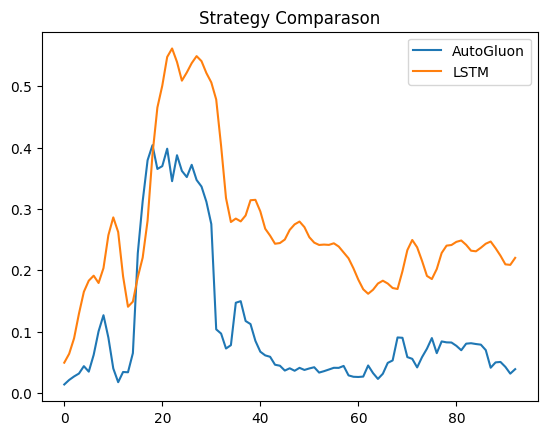

In [117]:
plt.plot(final_result['CF'],label='AutoGluon')
plt.plot(y_pred_future_30_days,label='LSTM')
plt.title('Strategy Comparason')
plt.legend()
plt.show()